# This notebook uses pytorch lightning & optuna & a Recurrent Attentive Neural Process for Sequential Data (RANPfSQ)

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

- similar to https://arxiv.org/abs/1910.09323

Results on *Smartmeter* prediction

|Model|val_loss|
|--|--| 
|ANP-RNN|-1.27|
|ANP-RNN_imp|-1.38|
|ANP|-1.3|
|ANP_impr|-1.2|
|NP|-1.3|

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
from src.models.model import LatentModel
from src.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from src.plot import plot_from_loader
from src.models.lightning_anp import LatentModelPL
from src.dict_logger import DictLogger

In [5]:
# Params
device='cuda'
use_logy=False

# Load kaggle smart meter data

In [6]:
df_train, df_test = get_smartmeter_df()
data_test = SmartMeterDataSet(
            df_test, 24*4, 24*4
)
x, y = data_test[0]
x.shape, y.shape

((192, 17), (192, 1))

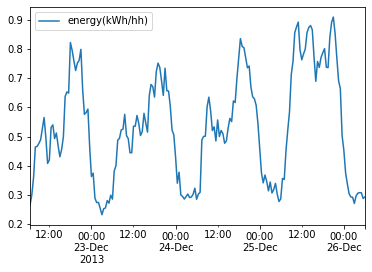

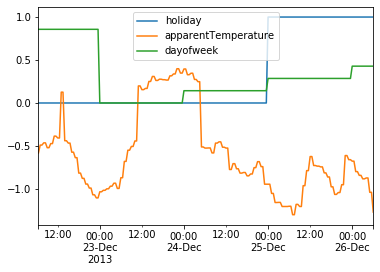

In [7]:
x_rows, y_rows = data_test.get_rows(670)
y_rows.plot()
x_rows.drop(columns=['windBearing', 'humidity', 'temperature', 'pressure', 'windSpeed', 'visibility',  'dewPoint', 'tstp', 'month','day','week','minute','hour','future']).plot()

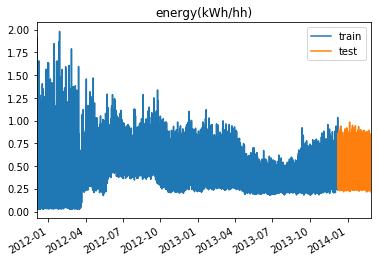

In [8]:
# Show split
df_train['energy(kWh/hh)'].plot(label='train')
df_test['energy(kWh/hh)'].plot(label='test')
plt.title('energy(kWh/hh)')
plt.legend()

# Default params

In [9]:
default_params = {
    'attention_dropout': 0,
    'attention_layers': 2,
    'batchnorm': False,
    'det_enc_cross_attn_type': 'multihead',
    'det_enc_self_attn_type': 'uniform',
    'dropout': 0,
    'hidden_dim': 64,
    'latent_dim': 32,
    'latent_enc_self_attn_type': 'uniform',
    'learning_rate': 2e-4,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
    'n_latent_encoder_layers': 2,
    'use_deterministic_path': True,
    'use_lvar': True,
    'use_rnn': False,
    'use_self_attn': True,
    'use_lstm_de': False,
    'use_lstm_d': False,
    'use_lstm_le': False,
}

In [10]:
user_attrs = {
    'batch_size': 16,
    'grad_clip': 40,
    'max_nb_epochs': 20,
    'num_workers': 4,
    'target_length': 24,
    'vis_i': '670',
    'num_context': 24*4,
    'num_extra_target': 24*4,
    'min_std': 0.005,
    'num_heads': 8,
    'context_in_target': True,
    'x_dim': x.shape[-1],
    'y_dim': y.shape[-1]
} 
user_attrs

{'batch_size': 16,
 'grad_clip': 40,
 'max_nb_epochs': 20,
 'num_workers': 4,
 'target_length': 24,
 'vis_i': '670',
 'num_context': 96,
 'num_extra_target': 96,
 'min_std': 0.005,
 'num_heads': 8,
 'context_in_target': True,
 'x_dim': 17,
 'y_dim': 1}

# Train helpers

In [11]:
PERCENT_TEST_EXAMPLES = 0.5
# name = 'anp-rnn4' # study name

MODEL_DIR = Path('.')/ 'optuna_result'/ 'anp-rnn4'
MODEL_DIR.mkdir(parents=True, exist_ok=True)
print(f"now run `tensorboard --logdir {MODEL_DIR}")

now run `tensorboard --logdir optuna_result/anp-rnn4


In [12]:
from pytorch_lightning.callbacks import EarlyStopping

In [13]:
def main(trial, train=False, name='anp-rnn', optuna=False): 
    """Setup pytorch lightning train."""
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

    # The default logger in PyTorch Lightning writes to event files to be consumed by
    # TensorBoard. We create a simple logger instead that holds the log in memory so that the
    # final accuracy can be obtained after optimization. When using the default logger, the
    # final accuracy could be stored in an attribute of the `Trainer` instead.
    logger = DictLogger(MODEL_DIR, name=name, version=trial.number)
    
    if optuna:
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    else:
        early_stop_callback = EarlyStopping(
            monitor='val_loss',
            min_delta=0.00,
            patience=2,
            verbose=True,
            mode='min'
        )
    

    trainer = pl.Trainer(
        logger=logger,
        val_percent_check=PERCENT_TEST_EXAMPLES,
        gradient_clip_val=trial.user_attrs["grad_clip"],
        checkpoint_callback=checkpoint_callback,
        max_epochs=trial.user_attrs['max_nb_epochs'],
        gpus=-1 if torch.cuda.is_available() else None,
        early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
    )
    model = LatentModelPL(dict(**trial.params, **trial.user_attrs))
    if train:
        trainer.fit(model)
    
    return model, trainer


def add_sugg(trial, name):
    """Add optuna suggestions and user attrs"""
    
    trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    trial.suggest_categorical("hidden_dim", [8*2**i for i in range(6)])
    trial.suggest_categorical("latent_dim", [8*2**i for i in range(6)])
    
    trial.suggest_int("attention_layers", 1, 4)
    trial.suggest_categorical("n_latent_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_det_encoder_layers", [1, 2, 4, 8])
    trial.suggest_categorical("n_decoder_layers", [1, 2, 4, 8])

    trial.suggest_categorical("dropout", [0, 0.2, 0.5])
    trial.suggest_categorical("attention_dropout", [0, 0.2, 0.5])

    trial.suggest_categorical(
        "latent_enc_self_attn_type", ['uniform', 'multihead', 'ptmultihead']
    )
    trial.suggest_categorical("det_enc_self_attn_type",  ['uniform', 'multihead', 'ptmultihead'])
    trial.suggest_categorical("det_enc_cross_attn_type", ['uniform', 'multihead', 'ptmultihead'])

    trial.suggest_categorical("batchnorm", [False, True])
    trial.suggest_categorical("use_self_attn", [False, True])
    trial.suggest_categorical("use_lvar", [False, True])
    trial.suggest_categorical("use_deterministic_path", [False, True])
    trial.suggest_categorical("use_rnn", [True, False])
    trial.suggest_categorical("use_lstm_le", [True, False])
    trial.suggest_categorical("use_lstm_de", [True, False])
    trial.suggest_categorical("use_lstm_d", [True, False])
    

    # non hyperparams, ones that we want to keep constant
    trial._user_attrs = user_attrs
    
    # For manual experiment we will start at -1 and deincr by 1
    versions = [int(s.stem.split('_')[-1]) for s in (MODEL_DIR / name).glob('version_*')] + [-1]
    trial.number = min(versions)-1
    print('trial.number', trial.number)
    
    return trial



In [14]:
def try_manual(params, name):
    """Run a manual trial using optuna"""
    params = {
        **default_params, 
        **params
    }
    trial = optuna.trial.FixedTrial(params)
    trial = add_sugg(trial, name=name)
    print(dict(params=trial.params, user_attrs=trial.user_attrs))
    model, trainer = main(trial, train=False, name=name)
    try:
        trainer.fit(model)
    except KeyboardInterrupt:
        pass

    # plot, main metric
    loader = model.val_dataloader()[0]
    vis_i=670
    plot_from_loader(loader, model, i=vis_i)

    r = trainer.test(model)
    model.logger.experiment.add_hparams(trial.params, model.logger.metrics[-1])
    print('logger.metrics', model.logger.metrics[-1:])
    print(r)
    return trainer, model, params, r

# TEMP

In [ ]:
trainer, model, params, r = try_manual({ 
    'det_enc_cross_attn_type': 'ptmultihead',
    'det_enc_self_attn_type': 'ptmultihead',
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_self_attn': False,
    'use_lvar': True,
    'use_deterministic_path': False,
    'use_rnn': True,
    'use_lstm_d': True,
}, name='anp-rnn3b')

trial.number -10
{'params': {'learning_rate': 0.0002, 'hidden_dim': 64, 'latent_dim': 32, 'attention_layers': 2, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 2, 'n_decoder_layers': 2, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'det_enc_cross_attn_type': 'ptmultihead', 'batchnorm': False, 'use_self_attn': False, 'use_lvar': True, 'use_deterministic_path': False, 'use_rnn': True, 'use_lstm_le': False, 'use_lstm_de': False, 'use_lstm_d': True}, 'user_attrs': {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': '670', 'num_context': 96, 'num_extra_target': 96, 'min_std': 0.005, 'num_heads': 8, 'context_in_target': True, 'x_dim': 17, 'y_dim': 1}}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0


In [ ]:
trainer, model, params, r = try_manual({ 
    'det_enc_cross_attn_type': 'ptmultihead',
    'det_enc_self_attn_type': 'ptmultihead',
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_self_attn': True,
    'use_lvar': False,
    'use_deterministic_path': False,
    'use_rnn': True,
    'use_lstm_d': True,
}, name='anp-rnn3c')

In [ ]:
trainer, model, params, r = try_manual({ 
    'det_enc_cross_attn_type': 'ptmultihead',
    'det_enc_self_attn_type': 'ptmultihead',
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_self_attn': True,
    'use_lvar': False,
    'use_deterministic_path': True,
    'use_rnn': True,
    'use_lstm_d': True,
}, name='anp-rnn3d')

#  Train all the features

trial.number -16
{'params': {'learning_rate': 0.001, 'hidden_dim': 64, 'latent_dim': 16, 'attention_layers': 2, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 2, 'n_decoder_layers': 2, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'det_enc_cross_attn_type': 'ptmultihead', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': True, 'use_deterministic_path': False, 'use_rnn': False, 'use_lstm_le': True, 'use_lstm_de': True, 'use_lstm_d': True}, 'user_attrs': {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': '670', 'num_context': 96, 'num_extra_target': 96, 'min_std': 0.005, 'num_heads': 8, 'context_in_target': True, 'x_dim': 17, 'y_dim': 1}}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                                 Name                  Type  \
0                                               model           LatentModel   
1                               model._latent_encoder         LatentEncoder   
2                      model._latent_encoder._encoder             LSTMBlock   
3                model._latent_encoder._encoder._lstm                  LSTM   
4               model._latent_encoder._self_attention             Attention   
5            model._latent_encoder._self_attention._W    MultiheadAttention   
6   model._latent_encoder._self_attention._W.out_proj                Linear   
7            model._latent_encoder._penultimate_layer                Linear   
8                         model._latent_encoder._mean                Linear   
9                      model._latent_encoder._log_var                Linear   
10                       model._deterministic_encode

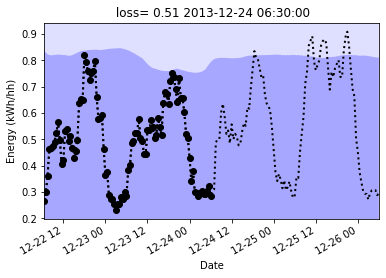

step val 0, {'val_loss': '0.5085236430168152', 'val/kl': '0.49787411093711853', 'val/mse': '0.38746461272239685', 'val/std': '0.9221398234367371'}


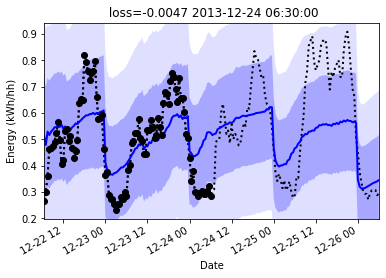

step val 2194, {'val_loss': '-0.003984351642429829', 'val/kl': '2.3832704698634188e-07', 'val/mse': '0.02420048601925373', 'val/std': '0.2019025683403015'}


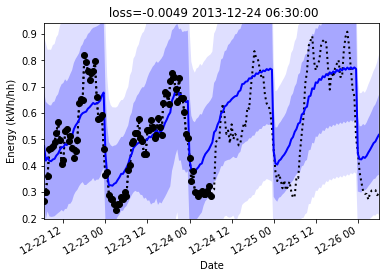

step val 4389, {'val_loss': '-0.0027924238238483667', 'val/kl': '2.8800699510611594e-05', 'val/mse': '0.03135362267494202', 'val/std': '0.24489343166351318'}


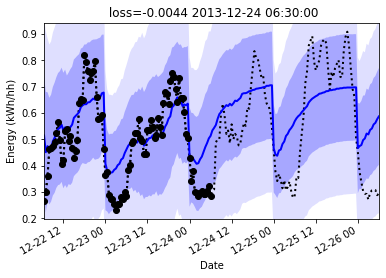

step val 6584, {'val_loss': '-0.003580363467335701', 'val/kl': '0.0002042064443230629', 'val/mse': '0.022447029128670692', 'val/std': '0.20456455647945404'}
Epoch     2: reducing learning rate of group 0 to 1.0000e-04.


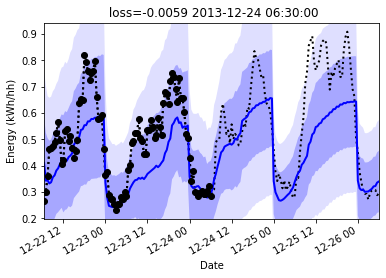

step val 8779, {'val_loss': '-0.005927325692027807', 'val/kl': '3.091991231940483e-07', 'val/mse': '0.018585311248898506', 'val/std': '0.18006542325019836'}


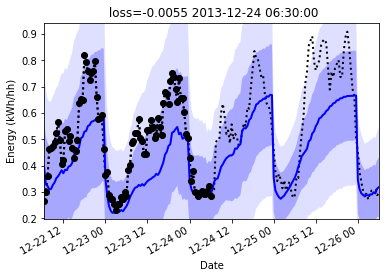

step val 10974, {'val_loss': '-0.00565463537350297', 'val/kl': '8.679926963850448e-07', 'val/mse': '0.020177507773041725', 'val/std': '0.18518686294555664'}


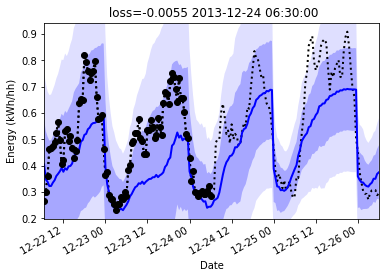

step val 13169, {'val_loss': '-0.005898784380406141', 'val/kl': '2.558767164373421e-06', 'val/mse': '0.019413426518440247', 'val/std': '0.18143008649349213'}
Epoch     5: reducing learning rate of group 0 to 1.0000e-05.


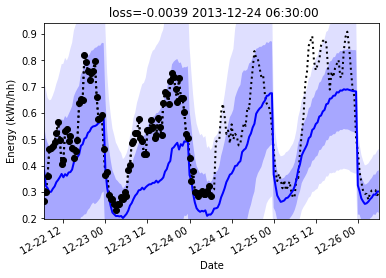

step val 15364, {'val_loss': '-0.005602153949439526', 'val/kl': '2.5039045681296557e-07', 'val/mse': '0.022906549274921417', 'val/std': '0.18583142757415771'}


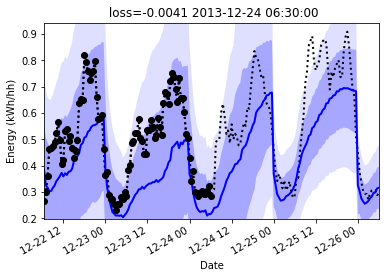

step val 17559, {'val_loss': '-0.005709900055080652', 'val/kl': '1.527369164477932e-07', 'val/mse': '0.022017942741513252', 'val/std': '0.18484126031398773'}
Epoch     7: reducing learning rate of group 0 to 1.0000e-06.


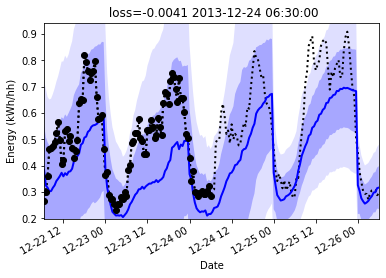

step val 19754, {'val_loss': '-0.005693569779396057', 'val/kl': '1.527369164477932e-07', 'val/mse': '0.02193894423544407', 'val/std': '0.18569044768810272'}


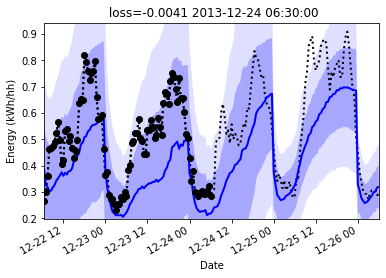

step val 21949, {'val_loss': '-0.0057144430465996265', 'val/kl': '1.527369164477932e-07', 'val/mse': '0.02170126885175705', 'val/std': '0.18559220433235168'}
Epoch     9: reducing learning rate of group 0 to 1.0000e-07.


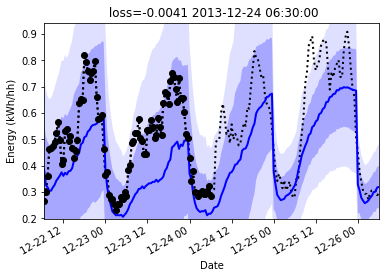

step val 24144, {'val_loss': '-0.005716560408473015', 'val/kl': '1.527369164477932e-07', 'val/mse': '0.021699121221899986', 'val/std': '0.1855170875787735'}


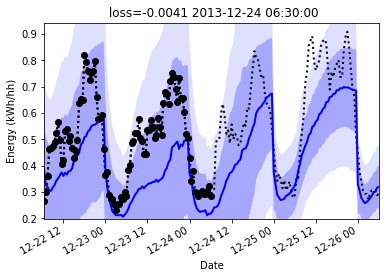

step val 26339, {'val_loss': '-0.005719610955566168', 'val/kl': '1.527369164477932e-07', 'val/mse': '0.021698089316487312', 'val/std': '0.1854107677936554'}


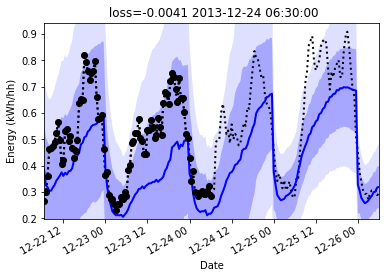

step val 28534, {'val_loss': '-0.005717901047319174', 'val/kl': '1.4901162614933128e-07', 'val/mse': '0.021708045154809952', 'val/std': '0.18544955551624298'}


INFO:root:
                                                 Name                  Type  \
0                                               model           LatentModel   
1                               model._latent_encoder         LatentEncoder   
2                      model._latent_encoder._encoder             LSTMBlock   
3                model._latent_encoder._encoder._lstm                  LSTM   
4               model._latent_encoder._self_attention             Attention   
5            model._latent_encoder._self_attention._W    MultiheadAttention   
6   model._latent_encoder._self_attention._W.out_proj                Linear   
7            model._latent_encoder._penultimate_layer                Linear   
8                         model._latent_encoder._mean                Linear   
9                      model._latent_encoder._log_var                Linear   
10                       model._deterministic_encoder  DeterministicEncoder   
11            model._deterministic_encode

KeyboardInterrupt: 

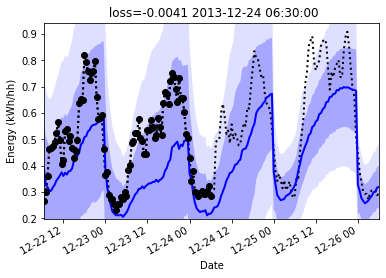

In [15]:
trainer, model, params, r = try_manual({
    'det_enc_cross_attn_type': 'ptmultihead',
    'det_enc_self_attn_type': 'ptmultihead',
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': True,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'hidden_dim': 64,
    'learning_rate': 1e-3,
    'latent_dim': 16,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
    'n_latent_encoder_layers': 2,
}, name='anp-lstm6')

In [ ]:
trainer, model, params, r = try_manual({
    'det_enc_cross_attn_type': 'ptmultihead',
    'det_enc_self_attn_type': 'ptmultihead',
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': True,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'hidden_dim': 256,
    'learning_rate': 1e-3,
    'latent_dim': 16,
    'n_decoder_layers': 4,
    'n_det_encoder_layers': 2,
    'n_latent_encoder_layers': 2,
}, name='anp-lstm6')

trial.number -18
{'params': {'learning_rate': 0.001, 'hidden_dim': 64, 'latent_dim': 8, 'attention_layers': 2, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 2, 'n_decoder_layers': 2, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'det_enc_cross_attn_type': 'ptmultihead', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': False, 'use_deterministic_path': True, 'use_rnn': False, 'use_lstm_le': True, 'use_lstm_de': True, 'use_lstm_d': True}, 'user_attrs': {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': '670', 'num_context': 96, 'num_extra_target': 96, 'min_std': 0.005, 'num_heads': 8, 'context_in_target': True, 'x_dim': 17, 'y_dim': 1}}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                                 Name                  Type  \
0                                               model           LatentModel   
1                               model._latent_encoder         LatentEncoder   
2                      model._latent_encoder._encoder             LSTMBlock   
3                model._latent_encoder._encoder._lstm                  LSTM   
4               model._latent_encoder._self_attention             Attention   
5            model._latent_encoder._self_attention._W    MultiheadAttention   
6   model._latent_encoder._self_attention._W.out_proj                Linear   
7            model._latent_encoder._penultimate_layer                Linear   
8                         model._latent_encoder._mean                Linear   
9                      model._latent_encoder._log_var                Linear   
10                       model._deterministic_encode

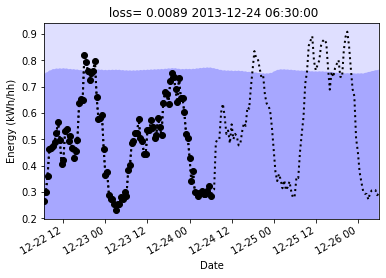

step val 0, {'val_loss': '0.008372780866920948', 'val/kl': '4.591694505506894e-06', 'val/mse': '0.2565266788005829', 'val/std': '0.7180030941963196'}


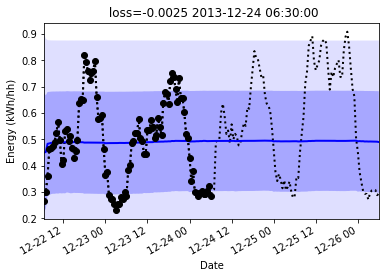

step val 2194, {'val_loss': '-0.002927496563643217', 'val/kl': '2.29970158471815e-08', 'val/mse': '0.03249514102935791', 'val/std': '0.18759384751319885'}


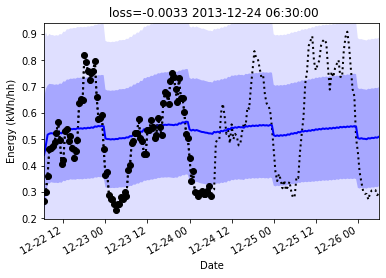

step val 4389, {'val_loss': '-0.003864825936034322', 'val/kl': '1.2245789093867643e-07', 'val/mse': '0.02650538459420204', 'val/std': '0.17759689688682556'}


INFO:root:
                                                 Name                  Type  \
0                                               model           LatentModel   
1                               model._latent_encoder         LatentEncoder   
2                      model._latent_encoder._encoder             LSTMBlock   
3                model._latent_encoder._encoder._lstm                  LSTM   
4               model._latent_encoder._self_attention             Attention   
5            model._latent_encoder._self_attention._W    MultiheadAttention   
6   model._latent_encoder._self_attention._W.out_proj                Linear   
7            model._latent_encoder._penultimate_layer                Linear   
8                         model._latent_encoder._mean                Linear   
9                      model._latent_encoder._log_var                Linear   
10                       model._deterministic_encoder  DeterministicEncoder   
11            model._deterministic_encode

KeyboardInterrupt: 

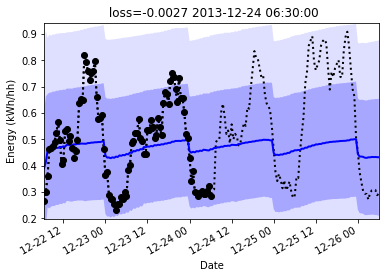

In [17]:
trainer, model, params, r = try_manual({
    'det_enc_cross_attn_type': 'ptmultihead',
    'det_enc_self_attn_type': 'ptmultihead',
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': True,
    'use_rnn': False,
    'use_lvar': False,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'hidden_dim': 64,
    'learning_rate': 1e-3,
    'latent_dim': 8,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
    'n_latent_encoder_layers': 2,
}, name='anp-lstm6')

trial.number -4
{'params': {'learning_rate': 0.0002, 'hidden_dim': 128, 'latent_dim': 32, 'attention_layers': 2, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 2, 'n_decoder_layers': 4, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'uniform', 'det_enc_cross_attn_type': 'multihead', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': False, 'use_deterministic_path': False, 'use_rnn': False, 'use_lstm_le': True, 'use_lstm_de': True, 'use_lstm_d': True}, 'user_attrs': {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': '670', 'num_context': 96, 'num_extra_target': 96, 'min_std': 0.005, 'num_heads': 8, 'context_in_target': True, 'x_dim': 17, 'y_dim': 1}}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                     Name           Type Params
0                                   model    LatentModel    1 M
1                   model._latent_encoder  LatentEncoder  296 K
2          model._latent_encoder._encoder      LSTMBlock  205 K
3    model._latent_encoder._encoder._lstm           LSTM  205 K
4   model._latent_encoder._self_attention      Attention   65 K
..                                    ...            ...    ...
83       model._decoder._target_transform         Linear    2 K
84                model._decoder._decoder      LSTMBlock  819 K
85          model._decoder._decoder._lstm           LSTM  819 K
86                   model._decoder._mean         Linear  161  
87                    model._decoder._std         Linear  161  

[88 rows x 3 columns]


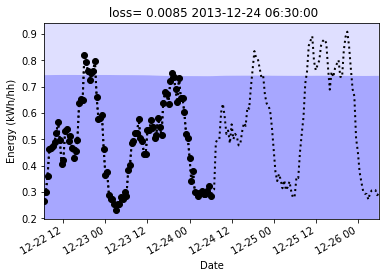

step val 0, {'val_loss': '0.008190018124878407', 'val/kl': '3.4992096971109277e-06', 'val/mse': '0.24510645866394043', 'val/std': '0.7086239457130432'}


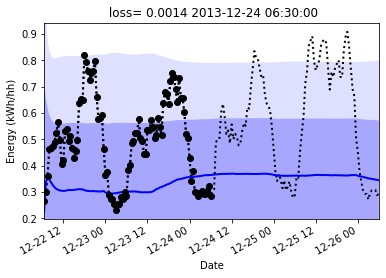

step val 2194, {'val_loss': '0.0009820184204727411', 'val/kl': '4.15197791880928e-06', 'val/mse': '0.06968669593334198', 'val/std': '0.25701361894607544'}


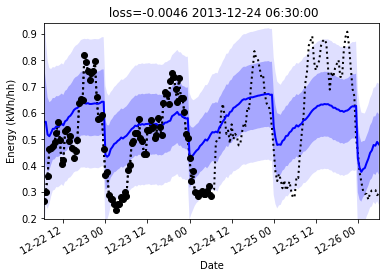

step val 4389, {'val_loss': '-0.003067978424951434', 'val/kl': '0.00041899431380443275', 'val/mse': '0.023436274379491806', 'val/std': '0.11854680627584457'}


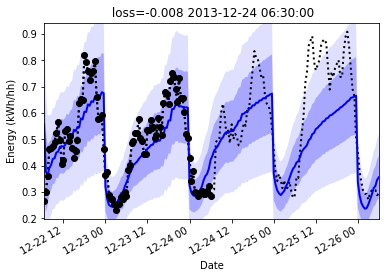

step val 6584, {'val_loss': '-0.008892255835235119', 'val/kl': '0.00013503446825779974', 'val/mse': '0.011026803404092789', 'val/std': '0.10993742942810059'}


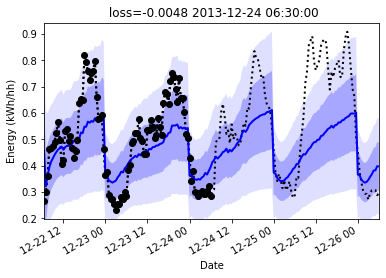

step val 8779, {'val_loss': '-0.006615653168410063', 'val/kl': '0.0001814078277675435', 'val/mse': '0.016692334786057472', 'val/std': '0.11418922245502472'}


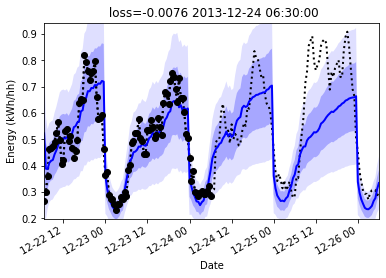

step val 10974, {'val_loss': '-0.010166539810597897', 'val/kl': '0.00016344485629815608', 'val/mse': '0.00950897578150034', 'val/std': '0.09235991537570953'}


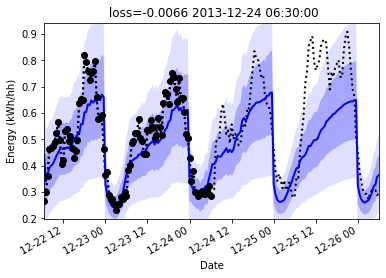

step val 13169, {'val_loss': '-0.009591312147676945', 'val/kl': '0.00016994816542137414', 'val/mse': '0.01029560063034296', 'val/std': '0.10637214034795761'}


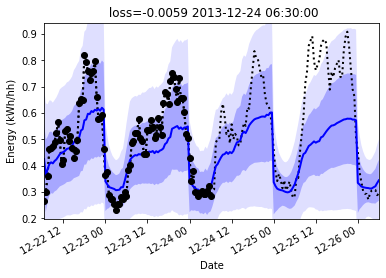

step val 15364, {'val_loss': '-0.008021118119359016', 'val/kl': '0.00017524346185382456', 'val/mse': '0.014622322283685207', 'val/std': '0.12971988320350647'}
Epoch     6: reducing learning rate of group 0 to 2.0000e-05.


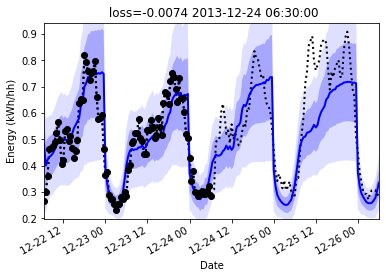

step val 17559, {'val_loss': '-0.010612783953547478', 'val/kl': '0.00033533747773617506', 'val/mse': '0.009035433642566204', 'val/std': '0.09748011082410812'}


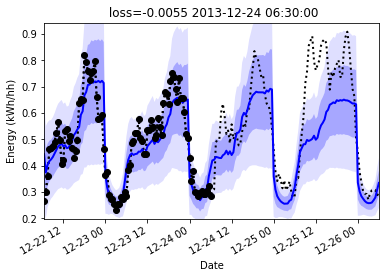

step val 19754, {'val_loss': '-0.010524552315473557', 'val/kl': '0.0002253891434520483', 'val/mse': '0.009040718898177147', 'val/std': '0.09352131932973862'}


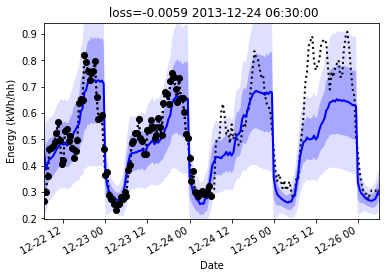

step val 21949, {'val_loss': '-0.010794165544211864', 'val/kl': '0.00019710721971932799', 'val/mse': '0.008825174532830715', 'val/std': '0.09773360937833786'}


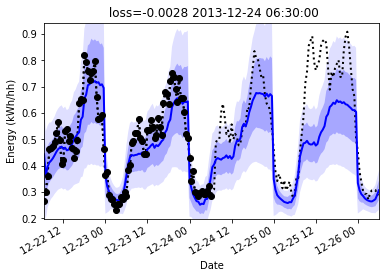

step val 24144, {'val_loss': '-0.010612767189741135', 'val/kl': '0.00019166663696523756', 'val/mse': '0.00894190464168787', 'val/std': '0.09138740599155426'}


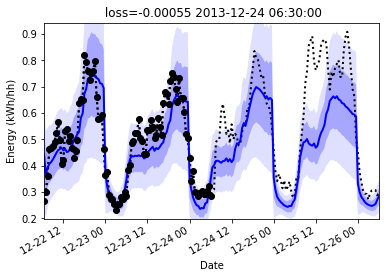

step val 26339, {'val_loss': '-0.010348288342356682', 'val/kl': '0.00016494494047947228', 'val/mse': '0.008815926499664783', 'val/std': '0.08906591683626175'}
Epoch    11: reducing learning rate of group 0 to 2.0000e-06.


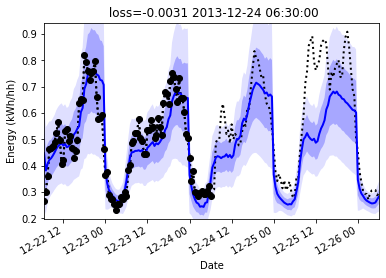

step val 28534, {'val_loss': '-0.011110018938779831', 'val/kl': '0.0001713246456347406', 'val/mse': '0.008221900090575218', 'val/std': '0.08888065069913864'}


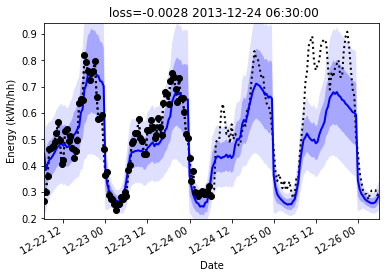

step val 30729, {'val_loss': '-0.010984753258526325', 'val/kl': '0.00017410304280929267', 'val/mse': '0.008399827405810356', 'val/std': '0.08902556449174881'}


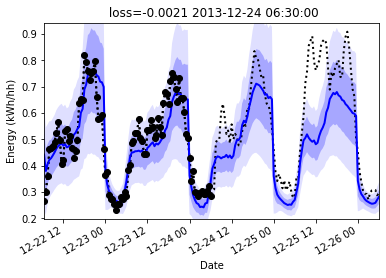

step val 32924, {'val_loss': '-0.010961978696286678', 'val/kl': '0.00017097800446208566', 'val/mse': '0.008336267434060574', 'val/std': '0.08819373697042465'}
Epoch    14: reducing learning rate of group 0 to 2.0000e-07.


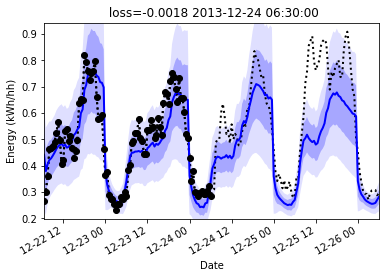

step val 35119, {'val_loss': '-0.01091832760721445', 'val/kl': '0.00017027596186380833', 'val/mse': '0.008378414437174797', 'val/std': '0.087855763733387'}


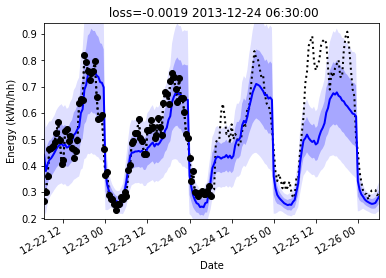

step val 37314, {'val_loss': '-0.010926739312708378', 'val/kl': '0.00016940414207056165', 'val/mse': '0.008370951749384403', 'val/std': '0.08774425834417343'}
Epoch    16: reducing learning rate of group 0 to 1.0000e-07.


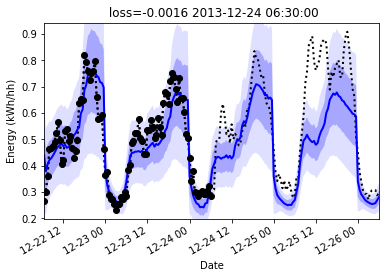

step val 39509, {'val_loss': '-0.010903109796345234', 'val/kl': '0.0001695368846412748', 'val/mse': '0.008374093100428581', 'val/std': '0.08751139789819717'}


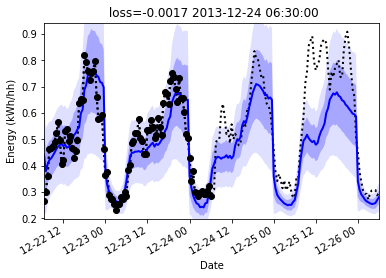

step val 41704, {'val_loss': '-0.0109071871265769', 'val/kl': '0.00016952535952441394', 'val/mse': '0.008369932882487774', 'val/std': '0.08751756697893143'}


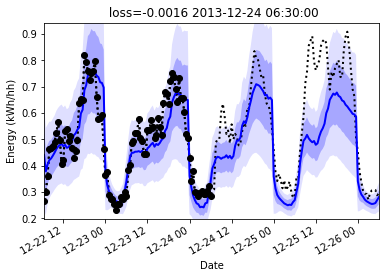

step val 43899, {'val_loss': '-0.010898778215050697', 'val/kl': '0.00016938966291490942', 'val/mse': '0.008380490355193615', 'val/std': '0.08737561106681824'}



INFO:root:
                                     Name           Type Params
0                                   model    LatentModel    1 M
1                   model._latent_encoder  LatentEncoder  296 K
2          model._latent_encoder._encoder      LSTMBlock  205 K
3    model._latent_encoder._encoder._lstm           LSTM  205 K
4   model._latent_encoder._self_attention      Attention   65 K
..                                    ...            ...    ...
83       model._decoder._target_transform         Linear    2 K
84                model._decoder._decoder      LSTMBlock  819 K
85          model._decoder._decoder._lstm           LSTM  819 K
86                   model._decoder._mean         Linear  161  
87                    model._decoder._std         Linear  161  

[88 rows x 3 columns]
INFO:root:model and trainer restored from checkpoint: optuna_result/anp-rnn4/anp-lstm5/version_-4/chk/_ckpt_epoch_12.ckpt


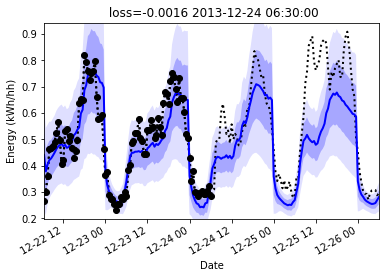

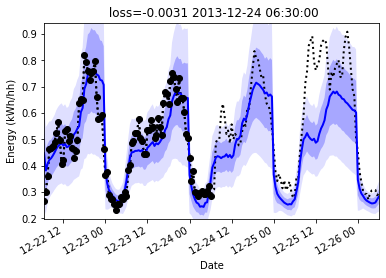

step val 28534, {'val_loss': '-0.011962966993451118', 'val/kl': '0.00012462273298297077', 'val/mse': '0.007574227172881365', 'val/std': '0.08558832854032516'}

logger.metrics [{'val_loss': -0.011962966993451118, 'val/kl': 0.00012462273298297077, 'val/mse': 0.007574227172881365, 'val/std': 0.08558832854032516, 'epoch': 12}]
None


In [19]:
trainer, model, params, r = try_manual({
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': False,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'hidden_dim': 128,
    'latent_dim': 32,
    'n_decoder_layers': 4,
    'n_det_encoder_layers': 2,
}, name='anp-lstm5')

trial.number -6
{'params': {'learning_rate': 0.0001, 'hidden_dim': 64, 'latent_dim': 32, 'attention_layers': 2, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 2, 'n_decoder_layers': 2, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'ptmultihead', 'det_enc_cross_attn_type': 'ptmultihead', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': True, 'use_deterministic_path': True, 'use_rnn': True, 'use_lstm_le': True, 'use_lstm_de': True, 'use_lstm_d': True}, 'user_attrs': {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': '670', 'num_context': 96, 'num_extra_target': 96, 'min_std': 0.005, 'num_heads': 8, 'context_in_target': True, 'x_dim': 17, 'y_dim': 1}}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                                 Name                  Type  \
0                                               model           LatentModel   
1                                         model._lstm                  LSTM   
2                               model._latent_encoder         LatentEncoder   
3                      model._latent_encoder._encoder             LSTMBlock   
4                model._latent_encoder._encoder._lstm                  LSTM   
5               model._latent_encoder._self_attention             Attention   
6            model._latent_encoder._self_attention._W    MultiheadAttention   
7   model._latent_encoder._self_attention._W.out_proj                Linear   
8            model._latent_encoder._penultimate_layer                Linear   
9                         model._latent_encoder._mean                Linear   
10                     model._latent_encoder._log_va

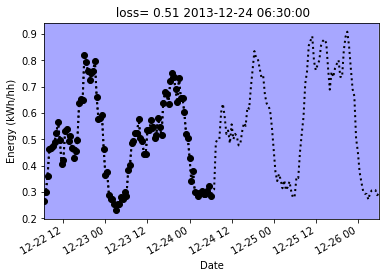

step val 0, {'val_loss': '0.5052782297134399', 'val/kl': '0.49425050616264343', 'val/mse': '0.27127805352211', 'val/std': '1.0668034553527832'}


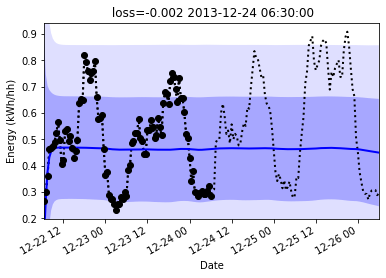

step val 2194, {'val_loss': '-0.002188278129324317', 'val/kl': '4.0865576011128724e-05', 'val/mse': '0.03710660710930824', 'val/std': '0.21274274587631226'}


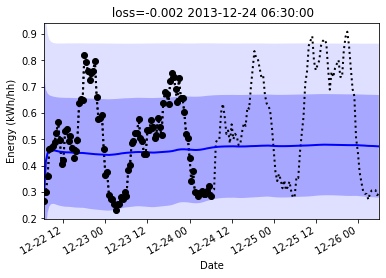

step val 4389, {'val_loss': '-0.002021251479163766', 'val/kl': '1.3534339814214036e-05', 'val/mse': '0.03771710768342018', 'val/std': '0.21960140764713287'}


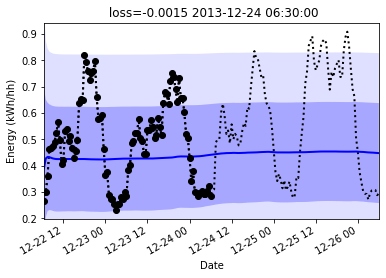

step val 6584, {'val_loss': '-0.0019393200054764748', 'val/kl': '2.3988948669284582e-05', 'val/mse': '0.039472002536058426', 'val/std': '0.20427018404006958'}
Epoch     2: reducing learning rate of group 0 to 1.0000e-05.


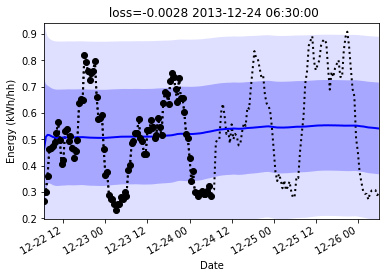

step val 8779, {'val_loss': '-0.0027623369824141264', 'val/kl': '1.1000141967087984e-05', 'val/mse': '0.03337840735912323', 'val/std': '0.18650378286838531'}


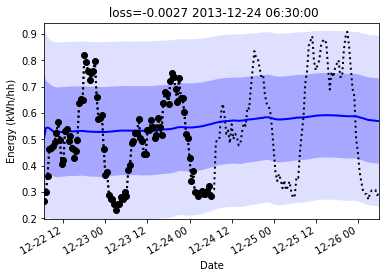

step val 10974, {'val_loss': '-0.002599900122731924', 'val/kl': '1.0187699444941245e-05', 'val/mse': '0.034077633172273636', 'val/std': '0.17086613178253174'}


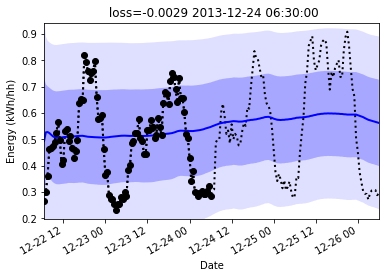

step val 13169, {'val_loss': '-0.002827542368322611', 'val/kl': '9.402587238582782e-06', 'val/mse': '0.03291347250342369', 'val/std': '0.17653970420360565'}


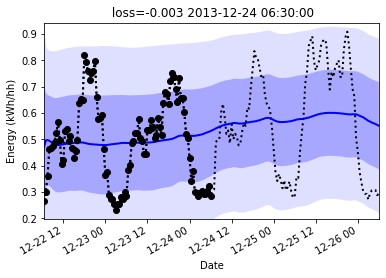

step val 15364, {'val_loss': '-0.0028915947768837214', 'val/kl': '9.437450898985844e-06', 'val/mse': '0.03248235210776329', 'val/std': '0.18120379745960236'}


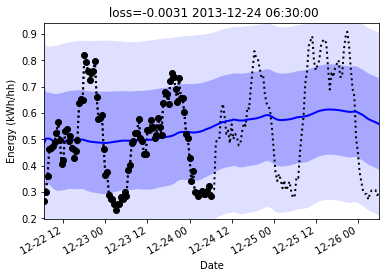

step val 17559, {'val_loss': '-0.002906778594478965', 'val/kl': '9.322450750914868e-06', 'val/mse': '0.03235269710421562', 'val/std': '0.188089057803154'}


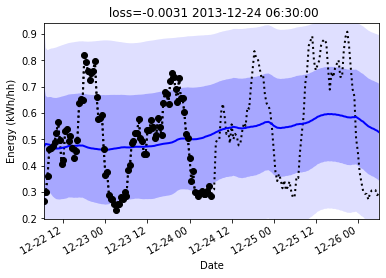

step val 19754, {'val_loss': '-0.0027920163702219725', 'val/kl': '8.951024938141927e-06', 'val/mse': '0.03259593993425369', 'val/std': '0.20000366866588593'}


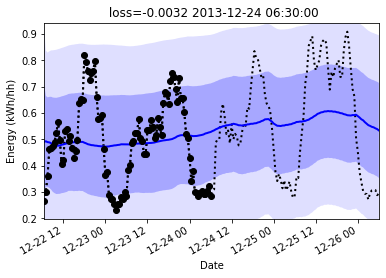

step val 21949, {'val_loss': '-0.002947590546682477', 'val/kl': '8.737481948628556e-06', 'val/mse': '0.03213076293468475', 'val/std': '0.18930380046367645'}


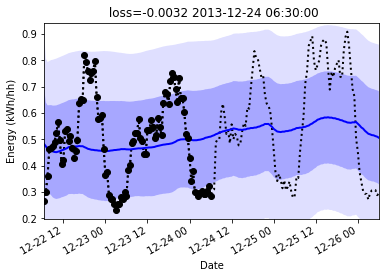

step val 24144, {'val_loss': '-0.0029352051205933094', 'val/kl': '9.028989552462008e-06', 'val/mse': '0.03233514353632927', 'val/std': '0.18546462059020996'}


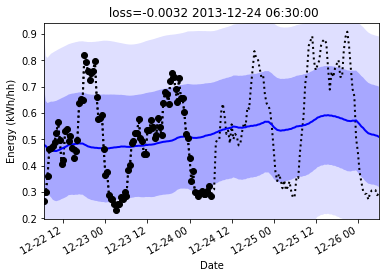

step val 26339, {'val_loss': '-0.0029106319416314363', 'val/kl': '9.23961397347739e-06', 'val/mse': '0.03193666413426399', 'val/std': '0.1977393925189972'}
Epoch    11: reducing learning rate of group 0 to 1.0000e-06.


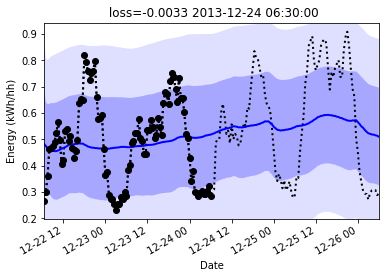

step val 28534, {'val_loss': '-0.0029717704746872187', 'val/kl': '9.242820851795841e-06', 'val/mse': '0.03191959485411644', 'val/std': '0.19130319356918335'}


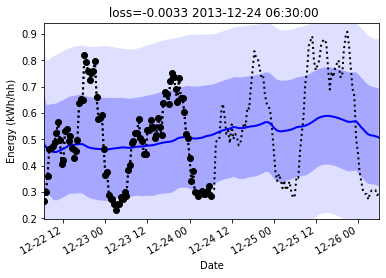

step val 30729, {'val_loss': '-0.002969802124425769', 'val/kl': '9.306366337114014e-06', 'val/mse': '0.03194628655910492', 'val/std': '0.19132982194423676'}


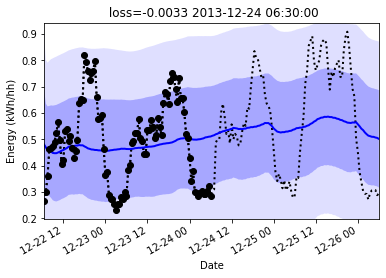

step val 32924, {'val_loss': '-0.0029645406175404787', 'val/kl': '9.365199730382301e-06', 'val/mse': '0.032041799277067184', 'val/std': '0.190239816904068'}
Epoch    14: reducing learning rate of group 0 to 1.0000e-07.


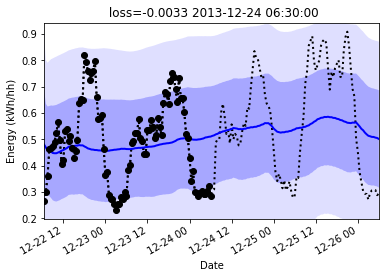

step val 35119, {'val_loss': '-0.0029631596989929676', 'val/kl': '9.369546205562074e-06', 'val/mse': '0.03204868361353874', 'val/std': '0.19027237594127655'}


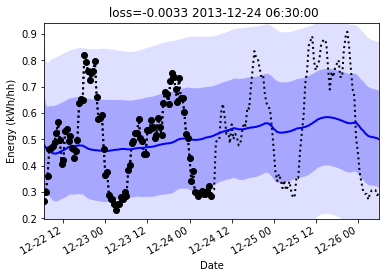

step val 37314, {'val_loss': '-0.0029636831022799015', 'val/kl': '9.381934432894923e-06', 'val/mse': '0.03206615149974823', 'val/std': '0.1897742599248886'}


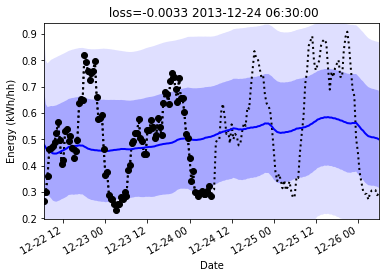

step val 39509, {'val_loss': '-0.0029622623696923256', 'val/kl': '9.408258847543038e-06', 'val/mse': '0.03206941857933998', 'val/std': '0.1899040788412094'}


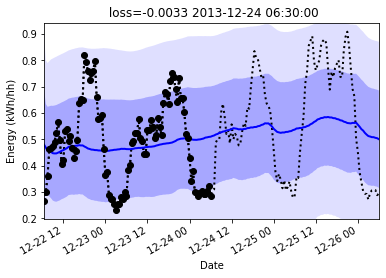

step val 41704, {'val_loss': '-0.0029599666595458984', 'val/kl': '9.418985428055748e-06', 'val/mse': '0.03205471113324165', 'val/std': '0.1905679702758789'}


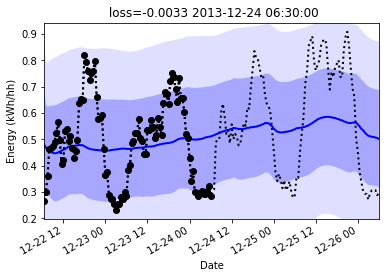

step val 43899, {'val_loss': '-0.002966966014355421', 'val/kl': '9.420636160939466e-06', 'val/mse': '0.03202836960554123', 'val/std': '0.19009733200073242'}



INFO:root:
                                                 Name                  Type  \
0                                               model           LatentModel   
1                                         model._lstm                  LSTM   
2                               model._latent_encoder         LatentEncoder   
3                      model._latent_encoder._encoder             LSTMBlock   
4                model._latent_encoder._encoder._lstm                  LSTM   
5               model._latent_encoder._self_attention             Attention   
6            model._latent_encoder._self_attention._W    MultiheadAttention   
7   model._latent_encoder._self_attention._W.out_proj                Linear   
8            model._latent_encoder._penultimate_layer                Linear   
9                         model._latent_encoder._mean                Linear   
10                     model._latent_encoder._log_var                Linear   
11                       model._determini

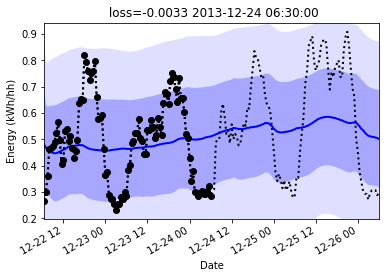

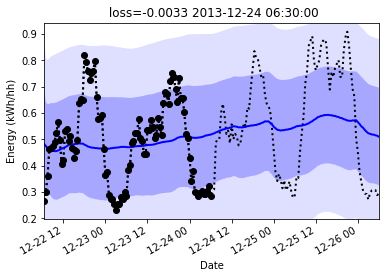

step val 28534, {'val_loss': '-0.003200475824996829', 'val/kl': '7.412088507408043e-06', 'val/mse': '0.029999542981386185', 'val/std': '0.1918984204530716'}

logger.metrics [{'val_loss': -0.003200475824996829, 'val/kl': 7.412088507408043e-06, 'val/mse': 0.029999542981386185, 'val/std': 0.1918984204530716, 'epoch': 12}]
None


In [20]:
trainer, model, params, r = try_manual({ 
    'det_enc_cross_attn_type': 'ptmultihead',
    'det_enc_self_attn_type': 'ptmultihead',
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': True,
    'learning_rate': 1e-4,
    'use_rnn': True,
    'use_lvar': True,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
}, name='anp-all')

trial.number -19
{'params': {'learning_rate': 0.0002, 'hidden_dim': 64, 'latent_dim': 8, 'attention_layers': 2, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 2, 'n_decoder_layers': 2, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'uniform', 'det_enc_cross_attn_type': 'multihead', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': True, 'use_deterministic_path': False, 'use_rnn': False, 'use_lstm_le': True, 'use_lstm_de': True, 'use_lstm_d': True}, 'user_attrs': {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': '670', 'num_context': 96, 'num_extra_target': 96, 'min_std': 0.005, 'num_heads': 8, 'context_in_target': True, 'x_dim': 17, 'y_dim': 1}}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                     Name           Type Params
0                                   model    LatentModel  354 K
1                   model._latent_encoder  LatentEncoder   75 K
2          model._latent_encoder._encoder      LSTMBlock   53 K
3    model._latent_encoder._encoder._lstm           LSTM   53 K
4   model._latent_encoder._self_attention      Attention   16 K
..                                    ...            ...    ...
83       model._decoder._target_transform         Linear    1 K
84                model._decoder._decoder      LSTMBlock   82 K
85          model._decoder._decoder._lstm           LSTM   82 K
86                   model._decoder._mean         Linear   73  
87                    model._decoder._std         Linear   73  

[88 rows x 3 columns]


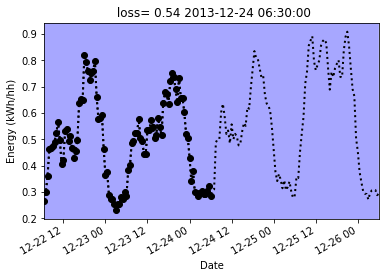

step val 0, {'val_loss': '0.5358594059944153', 'val/kl': '0.5247671008110046', 'val/mse': '0.24468183517456055', 'val/std': '1.0913124084472656'}


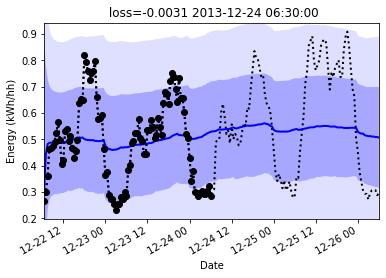

step val 2194, {'val_loss': '-0.0027933884412050247', 'val/kl': '2.2846250431030057e-05', 'val/mse': '0.031437989324331284', 'val/std': '0.20789821445941925'}


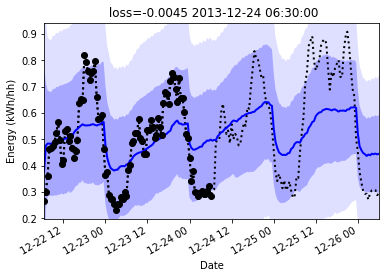

step val 4389, {'val_loss': '-0.004319900181144476', 'val/kl': '7.453332273144042e-06', 'val/mse': '0.02096719481050968', 'val/std': '0.20223674178123474'}


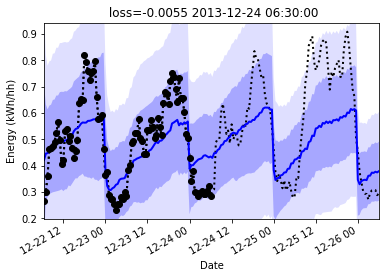

step val 6584, {'val_loss': '-0.00566378328949213', 'val/kl': '6.732973361067707e-06', 'val/mse': '0.01713225245475769', 'val/std': '0.17505408823490143'}


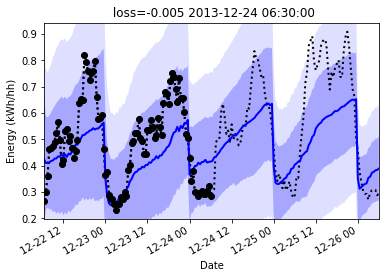

step val 8779, {'val_loss': '-0.005213335156440735', 'val/kl': '9.5108880486805e-06', 'val/mse': '0.017652323469519615', 'val/std': '0.1937984675168991'}


step val 10974, {'val_loss': '-0.004745598882436752', 'val/kl': '3.856590410578065e-06', 'val/mse': '0.01706770807504654', 'val/std': '0.22166411578655243'}
Epoch     4: reducing learning rate of group 0 to 2.0000e-05.


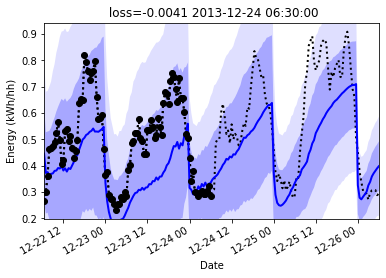

step val 13169, {'val_loss': '-0.005641731899231672', 'val/kl': '7.142567710616277e-07', 'val/mse': '0.01821429654955864', 'val/std': '0.19211283326148987'}


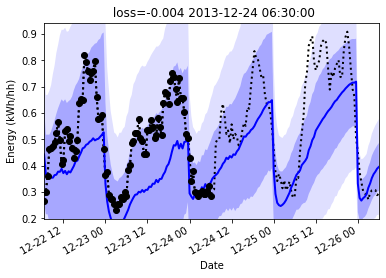

step val 15364, {'val_loss': '-0.005646527279168367', 'val/kl': '5.426864504443074e-07', 'val/mse': '0.018636565655469894', 'val/std': '0.19186292588710785'}
Epoch     6: reducing learning rate of group 0 to 2.0000e-06.


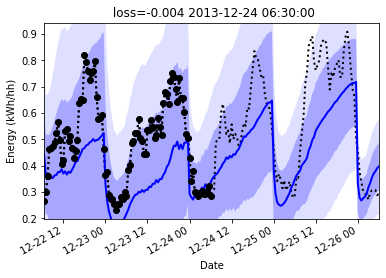

step val 17559, {'val_loss': '-0.005567645654082298', 'val/kl': '5.270728706818772e-07', 'val/mse': '0.018957214429974556', 'val/std': '0.19384433329105377'}


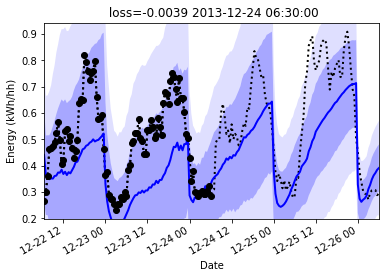

step val 19754, {'val_loss': '-0.005562034901231527', 'val/kl': '5.006336891710816e-07', 'val/mse': '0.019251681864261627', 'val/std': '0.19356031715869904'}
Epoch     8: reducing learning rate of group 0 to 2.0000e-07.


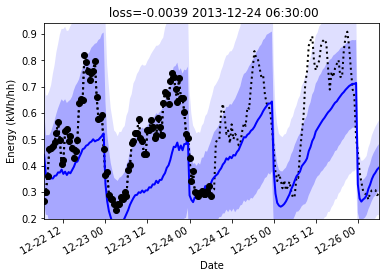

step val 21949, {'val_loss': '-0.005569803528487682', 'val/kl': '4.990058641851647e-07', 'val/mse': '0.019179964438080788', 'val/std': '0.1935560703277588'}


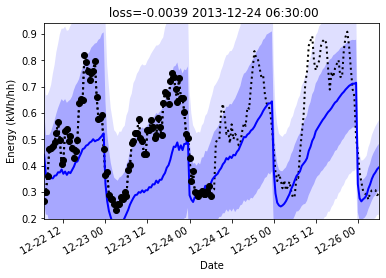

step val 24144, {'val_loss': '-0.005578130017966032', 'val/kl': '4.988267505723343e-07', 'val/mse': '0.019102293998003006', 'val/std': '0.19353371858596802'}
Epoch    10: reducing learning rate of group 0 to 1.0000e-07.


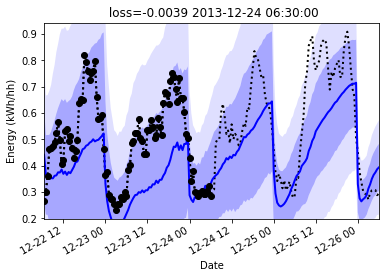

step val 26339, {'val_loss': '-0.005575817544013262', 'val/kl': '4.980824996891897e-07', 'val/mse': '0.019118105992674828', 'val/std': '0.19356988370418549'}


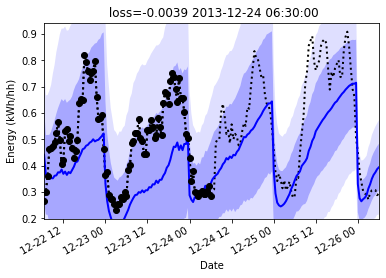

step val 28534, {'val_loss': '-0.005574060138314962', 'val/kl': '4.973541649633262e-07', 'val/mse': '0.019115792587399483', 'val/std': '0.19367016851902008'}


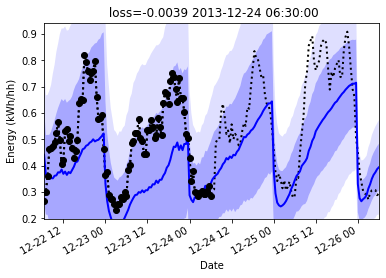

step val 30729, {'val_loss': '-0.005570110399276018', 'val/kl': '4.964626327819133e-07', 'val/mse': '0.01911250501871109', 'val/std': '0.19382217526435852'}


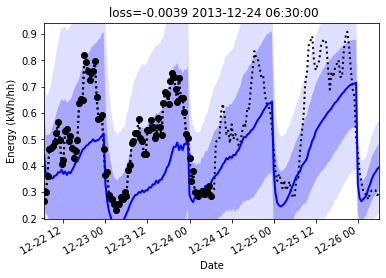

step val 32924, {'val_loss': '-0.005570405628532171', 'val/kl': '4.958815225108992e-07', 'val/mse': '0.019125359132885933', 'val/std': '0.19379860162734985'}


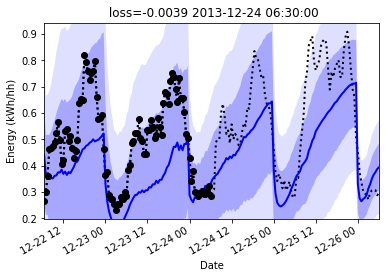

step val 35119, {'val_loss': '-0.005570224951952696', 'val/kl': '4.955830377184611e-07', 'val/mse': '0.019125351682305336', 'val/std': '0.19380998611450195'}


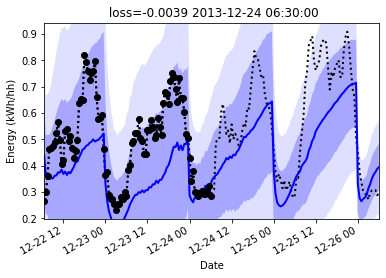

step val 37314, {'val_loss': '-0.005561257246881723', 'val/kl': '4.943094040754659e-07', 'val/mse': '0.019137324765324593', 'val/std': '0.1941056102514267'}


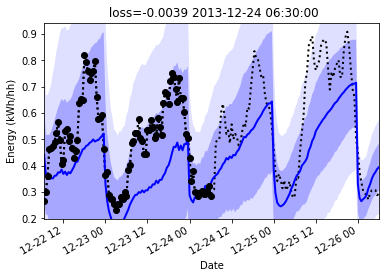

step val 39509, {'val_loss': '-0.005557962227612734', 'val/kl': '4.944407692164532e-07', 'val/mse': '0.01914464309811592', 'val/std': '0.1942128837108612'}


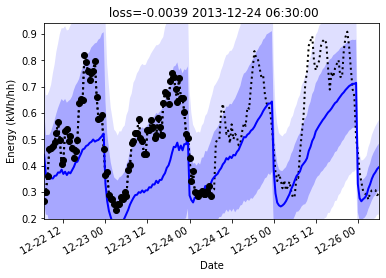

step val 41704, {'val_loss': '-0.00555702019482851', 'val/kl': '4.942417604070215e-07', 'val/mse': '0.019160469993948936', 'val/std': '0.19420984387397766'}


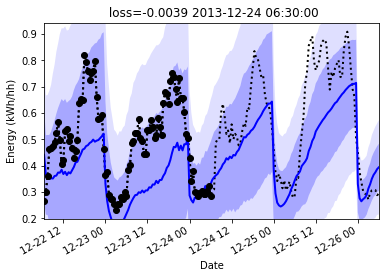

step val 43899, {'val_loss': '-0.005555609706789255', 'val/kl': '4.9354525799572e-07', 'val/mse': '0.019190678372979164', 'val/std': '0.19418029487133026'}



INFO:root:
                                     Name           Type Params
0                                   model    LatentModel  354 K
1                   model._latent_encoder  LatentEncoder   75 K
2          model._latent_encoder._encoder      LSTMBlock   53 K
3    model._latent_encoder._encoder._lstm           LSTM   53 K
4   model._latent_encoder._self_attention      Attention   16 K
..                                    ...            ...    ...
83       model._decoder._target_transform         Linear    1 K
84                model._decoder._decoder      LSTMBlock   82 K
85          model._decoder._decoder._lstm           LSTM   82 K
86                   model._decoder._mean         Linear   73  
87                    model._decoder._std         Linear   73  

[88 rows x 3 columns]
INFO:root:model and trainer restored from checkpoint: optuna_result/anp-rnn4/anp-lstm6/version_-19/chk/_ckpt_epoch_2.ckpt


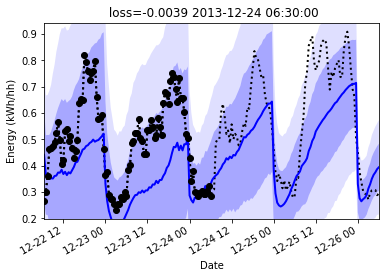

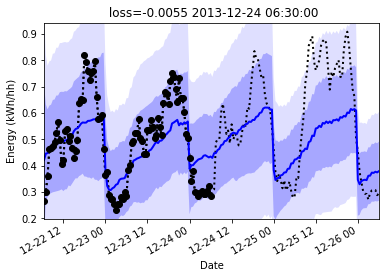

step val 6584, {'val_loss': '-0.005853107199072838', 'val/kl': '7.462896519427886e-06', 'val/mse': '0.01583925075829029', 'val/std': '0.17360518872737885'}

logger.metrics [{'val_loss': -0.005853107199072838, 'val/kl': 7.462896519427886e-06, 'val/mse': 0.01583925075829029, 'val/std': 0.17360518872737885, 'epoch': 2}]
None


In [21]:
trainer, model, params, r = try_manual({
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': True,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'hidden_dim': 64,
    'latent_dim': 8,
}, name='anp-lstm6')

trial.number -2
{'params': {'learning_rate': 0.0002, 'hidden_dim': 64, 'latent_dim': 32, 'attention_layers': 2, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 2, 'n_decoder_layers': 2, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'ptmultihead', 'det_enc_self_attn_type': 'uniform', 'det_enc_cross_attn_type': 'multihead', 'batchnorm': False, 'use_self_attn': True, 'use_lvar': True, 'use_deterministic_path': False, 'use_rnn': False, 'use_lstm_le': True, 'use_lstm_de': True, 'use_lstm_d': True}, 'user_attrs': {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': '670', 'num_context': 96, 'num_extra_target': 96, 'min_std': 0.005, 'num_heads': 8, 'context_in_target': True, 'x_dim': 17, 'y_dim': 1}}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                     Name           Type Params
0                                   model    LatentModel  422 K
1                   model._latent_encoder  LatentEncoder   78 K
2          model._latent_encoder._encoder      LSTMBlock   53 K
3    model._latent_encoder._encoder._lstm           LSTM   53 K
4   model._latent_encoder._self_attention      Attention   16 K
..                                    ...            ...    ...
83       model._decoder._target_transform         Linear    1 K
84                model._decoder._decoder      LSTMBlock  147 K
85          model._decoder._decoder._lstm           LSTM  147 K
86                   model._decoder._mean         Linear   97  
87                    model._decoder._std         Linear   97  

[88 rows x 3 columns]


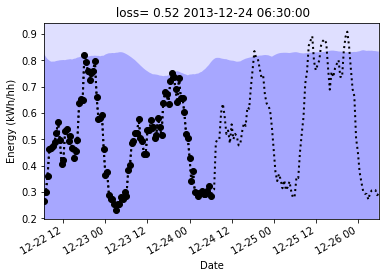

step val 0, {'val_loss': '0.5219016671180725', 'val/kl': '0.5112579464912415', 'val/mse': '0.3888452351093292', 'val/std': '0.9177885055541992'}


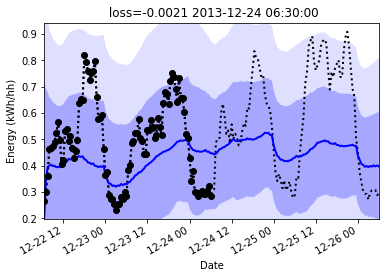

step val 2194, {'val_loss': '-0.001153977238573134', 'val/kl': '4.059112325194292e-05', 'val/mse': '0.04449738189578056', 'val/std': '0.2412676215171814'}


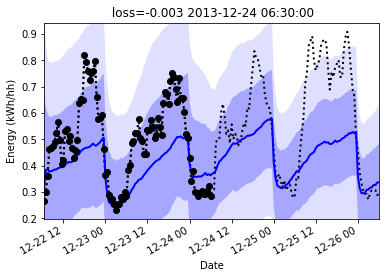

step val 4389, {'val_loss': '-0.002989626955240965', 'val/kl': '3.3985332265729085e-05', 'val/mse': '0.033970907330513', 'val/std': '0.2026766687631607'}


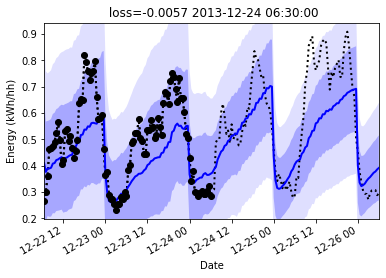

step val 6584, {'val_loss': '-0.00515104690566659', 'val/kl': '3.9791611925465986e-05', 'val/mse': '0.0198258887976408', 'val/std': '0.19118334352970123'}


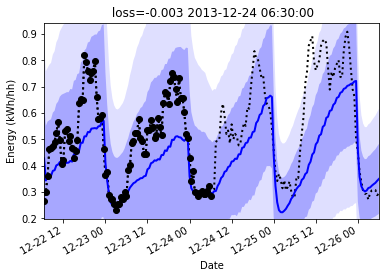

step val 8779, {'val_loss': '-0.0028277765959501266', 'val/kl': '2.9123417334631085e-05', 'val/mse': '0.023410072550177574', 'val/std': '0.27221348881721497'}


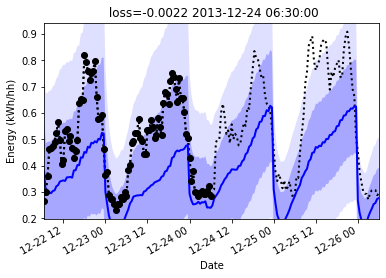

step val 10974, {'val_loss': '-0.003685848554596305', 'val/kl': '1.1342454854457173e-05', 'val/mse': '0.03251540660858154', 'val/std': '0.20473994314670563'}
Epoch     4: reducing learning rate of group 0 to 2.0000e-05.


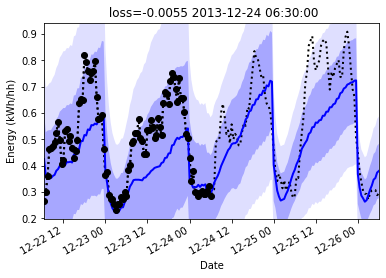

step val 13169, {'val_loss': '-0.0055043925531208515', 'val/kl': '4.485542376642115e-06', 'val/mse': '0.01916339062154293', 'val/std': '0.19730445742607117'}


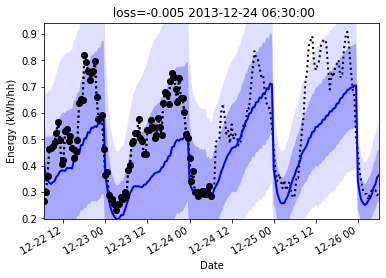

step val 15364, {'val_loss': '-0.005475978832691908', 'val/kl': '1.4046623846297734e-06', 'val/mse': '0.02090052142739296', 'val/std': '0.19480855762958527'}


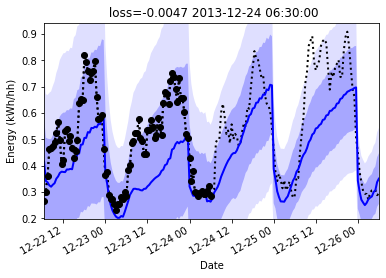

step val 17559, {'val_loss': '-0.005783900618553162', 'val/kl': '6.918413646417321e-07', 'val/mse': '0.019838465377688408', 'val/std': '0.18835186958312988'}


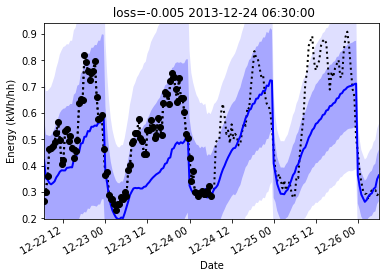

step val 19754, {'val_loss': '-0.005670316983014345', 'val/kl': '4.2205232375636115e-07', 'val/mse': '0.01964375749230385', 'val/std': '0.19565491378307343'}


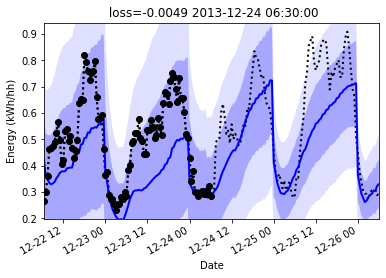

step val 21949, {'val_loss': '-0.005682311952114105', 'val/kl': '3.0670065598314977e-07', 'val/mse': '0.020291399210691452', 'val/std': '0.19391529262065887'}
Epoch     9: reducing learning rate of group 0 to 2.0000e-06.


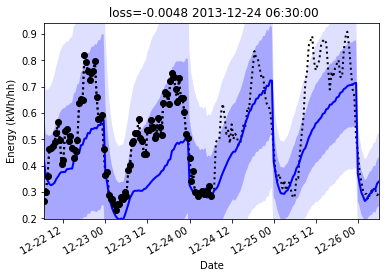

step val 24144, {'val_loss': '-0.005581430159509182', 'val/kl': '3.0763496283725544e-07', 'val/mse': '0.020435599610209465', 'val/std': '0.1972074657678604'}


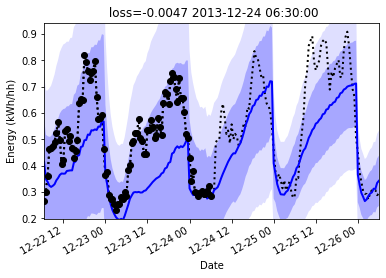

step val 26339, {'val_loss': '-0.00541901309043169', 'val/kl': '2.9316313998606347e-07', 'val/mse': '0.02146150916814804', 'val/std': '0.20053233206272125'}
Epoch    11: reducing learning rate of group 0 to 2.0000e-07.


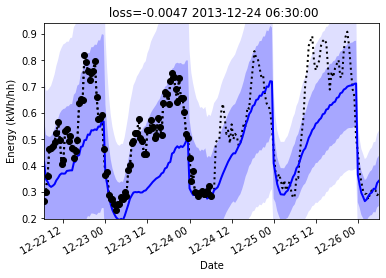

step val 28534, {'val_loss': '-0.005426726769655943', 'val/kl': '2.9130447387615277e-07', 'val/mse': '0.021415408700704575', 'val/std': '0.2003737986087799'}


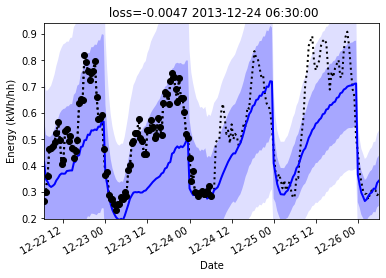

step val 30729, {'val_loss': '-0.005419209599494934', 'val/kl': '2.899109858844895e-07', 'val/mse': '0.02142636850476265', 'val/std': '0.20059052109718323'}
Epoch    13: reducing learning rate of group 0 to 1.0000e-07.


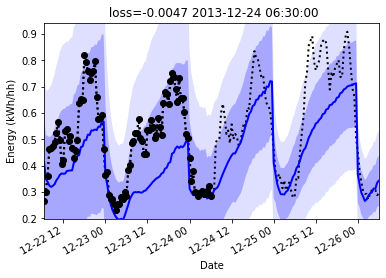

step val 32924, {'val_loss': '-0.005413149483501911', 'val/kl': '2.8902792337248684e-07', 'val/mse': '0.021432336419820786', 'val/std': '0.2007632851600647'}


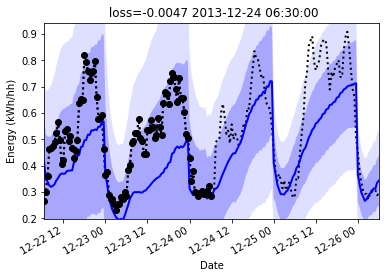

step val 35119, {'val_loss': '-0.005413081496953964', 'val/kl': '2.885174694711168e-07', 'val/mse': '0.0214337520301342', 'val/std': '0.2007668912410736'}


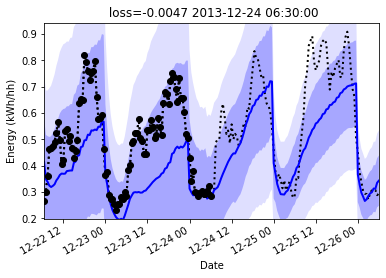

step val 37314, {'val_loss': '-0.005406233016401529', 'val/kl': '2.8793391493309173e-07', 'val/mse': '0.021471373736858368', 'val/std': '0.20092613995075226'}


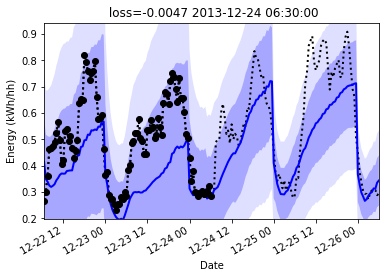

step val 39509, {'val_loss': '-0.005412280093878508', 'val/kl': '2.8685880693046784e-07', 'val/mse': '0.021411973983049393', 'val/std': '0.20086169242858887'}


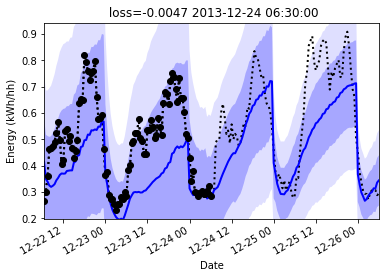

step val 41704, {'val_loss': '-0.0054167937487363815', 'val/kl': '2.857289871371904e-07', 'val/mse': '0.021380452439188957', 'val/std': '0.20080098509788513'}


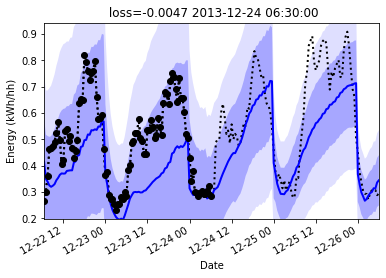

step val 43899, {'val_loss': '-0.005429975688457489', 'val/kl': '2.849250222425326e-07', 'val/mse': '0.021323125809431076', 'val/std': '0.20049400627613068'}



INFO:root:
                                     Name           Type Params
0                                   model    LatentModel  422 K
1                   model._latent_encoder  LatentEncoder   78 K
2          model._latent_encoder._encoder      LSTMBlock   53 K
3    model._latent_encoder._encoder._lstm           LSTM   53 K
4   model._latent_encoder._self_attention      Attention   16 K
..                                    ...            ...    ...
83       model._decoder._target_transform         Linear    1 K
84                model._decoder._decoder      LSTMBlock  147 K
85          model._decoder._decoder._lstm           LSTM  147 K
86                   model._decoder._mean         Linear   97  
87                    model._decoder._std         Linear   97  

[88 rows x 3 columns]
INFO:root:model and trainer restored from checkpoint: optuna_result/anp-rnn4/anp-lstm/version_-2/chk/_ckpt_epoch_7.ckpt


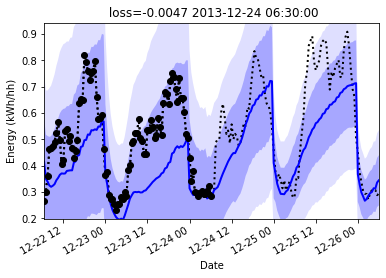

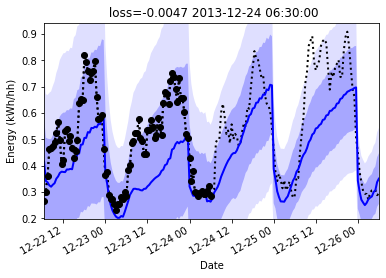

step val 17559, {'val_loss': '-0.006712715141475201', 'val/kl': '7.566235353806405e-07', 'val/mse': '0.015724945813417435', 'val/std': '0.17064779996871948'}

logger.metrics [{'val_loss': -0.006712715141475201, 'val/kl': 7.566235353806405e-07, 'val/mse': 0.015724945813417435, 'val/std': 0.17064779996871948, 'epoch': 7}]
None


In [22]:
trainer, model, params, r = try_manual({
    'latent_enc_self_attn_type': 'ptmultihead',
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': True,
    'use_self_attn': True,
    'use_lstm_le': True,
    'use_lstm_de': True,
    'use_lstm_d': True,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
}, name='anp-lstm')

trial.number -3
{'params': {'learning_rate': 0.0002, 'hidden_dim': 64, 'latent_dim': 32, 'attention_layers': 2, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 2, 'n_decoder_layers': 2, 'dropout': 0, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'uniform', 'det_enc_self_attn_type': 'uniform', 'det_enc_cross_attn_type': 'multihead', 'batchnorm': False, 'use_self_attn': False, 'use_lvar': False, 'use_deterministic_path': False, 'use_rnn': False, 'use_lstm_le': True, 'use_lstm_de': False, 'use_lstm_d': True}, 'user_attrs': {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': '670', 'num_context': 96, 'num_extra_target': 96, 'min_std': 0.005, 'num_heads': 8, 'context_in_target': True, 'x_dim': 17, 'y_dim': 1}}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                        Name           Type Params
0                                      model    LatentModel  357 K
1                      model._latent_encoder  LatentEncoder   62 K
2             model._latent_encoder._encoder      LSTMBlock   53 K
3       model._latent_encoder._encoder._lstm           LSTM   53 K
4   model._latent_encoder._penultimate_layer         Linear    4 K
..                                       ...            ...    ...
84          model._decoder._target_transform         Linear    1 K
85                   model._decoder._decoder      LSTMBlock  147 K
86             model._decoder._decoder._lstm           LSTM  147 K
87                      model._decoder._mean         Linear   97  
88                       model._decoder._std         Linear   97  

[89 rows x 3 columns]


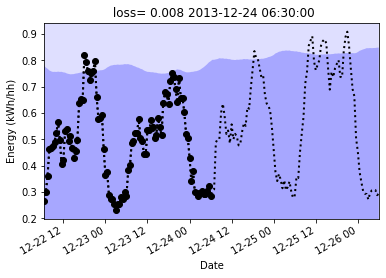

step val 0, {'val_loss': '0.007733847480267286', 'val/kl': '2.3517533918493427e-05', 'val/mse': '0.19875799119472504', 'val/std': '0.7051825523376465'}


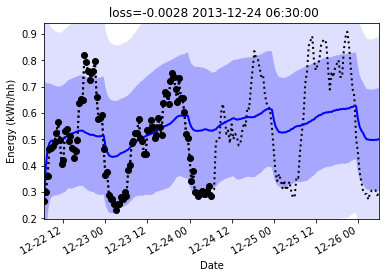

step val 2194, {'val_loss': '-0.002986733801662922', 'val/kl': '0.00011778482439694926', 'val/mse': '0.02662971429526806', 'val/std': '0.22472906112670898'}


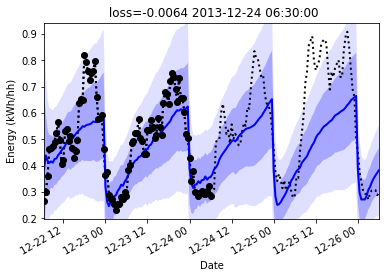

step val 4389, {'val_loss': '-0.006531161721795797', 'val/kl': '0.000743489246815443', 'val/mse': '0.014746601693332195', 'val/std': '0.11964130401611328'}


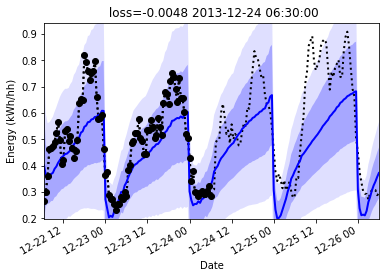

step val 6584, {'val_loss': '-0.007115930784493685', 'val/kl': '0.0005597397102974355', 'val/mse': '0.01381591521203518', 'val/std': '0.13169299066066742'}


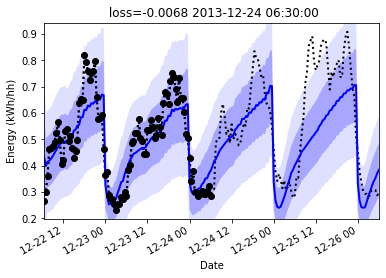

step val 8779, {'val_loss': '-0.008062330074608326', 'val/kl': '0.0004363165935501456', 'val/mse': '0.01201331801712513', 'val/std': '0.11051411926746368'}


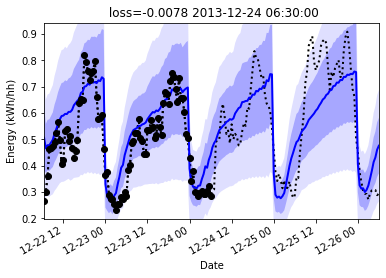

step val 10974, {'val_loss': '-0.006528726778924465', 'val/kl': '0.000416017253883183', 'val/mse': '0.014999675564467907', 'val/std': '0.1294754147529602'}


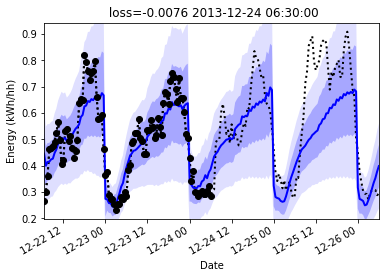

step val 13169, {'val_loss': '-0.008405983448028564', 'val/kl': '0.00032160425325855613', 'val/mse': '0.01186491921544075', 'val/std': '0.10649236291646957'}


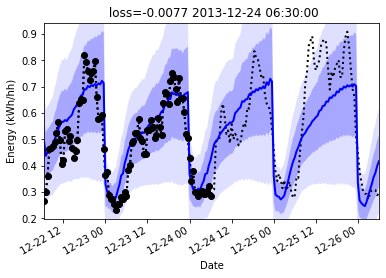

step val 15364, {'val_loss': '-0.007911313325166702', 'val/kl': '0.00029304364579729736', 'val/mse': '0.011830208823084831', 'val/std': '0.1265687346458435'}


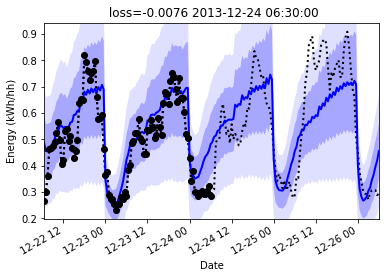

step val 17559, {'val_loss': '-0.00801269244402647', 'val/kl': '0.0002817984204739332', 'val/mse': '0.012281905859708786', 'val/std': '0.13109733164310455'}
Epoch     7: reducing learning rate of group 0 to 2.0000e-05.


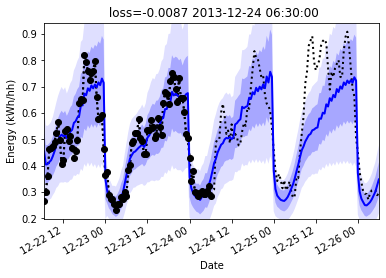

step val 19754, {'val_loss': '-0.01005187351256609', 'val/kl': '0.00017685777856968343', 'val/mse': '0.009164312854409218', 'val/std': '0.10425611585378647'}


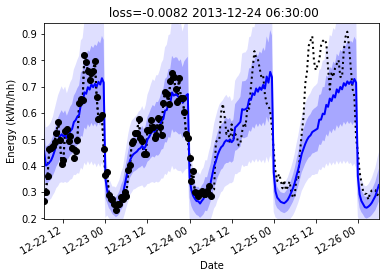

step val 21949, {'val_loss': '-0.010060490109026432', 'val/kl': '0.00014960518456064165', 'val/mse': '0.00911854300647974', 'val/std': '0.10415848344564438'}


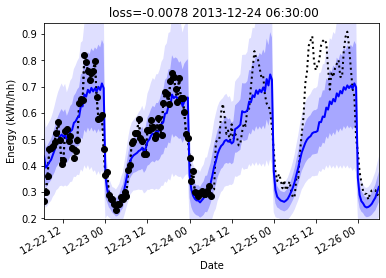

step val 24144, {'val_loss': '-0.010342671535909176', 'val/kl': '0.00015730121231172234', 'val/mse': '0.00903781782835722', 'val/std': '0.10455802083015442'}


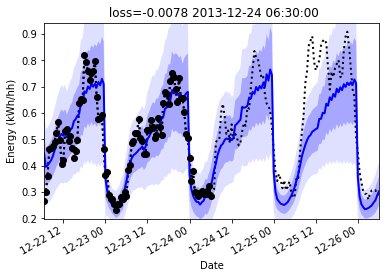

step val 26339, {'val_loss': '-0.010265772230923176', 'val/kl': '0.00015405852172989398', 'val/mse': '0.008912897668778896', 'val/std': '0.10303191095590591'}


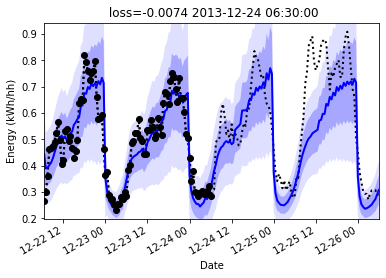

step val 28534, {'val_loss': '-0.010238764807581902', 'val/kl': '0.00014263643242884427', 'val/mse': '0.008888495154678822', 'val/std': '0.10088851302862167'}
Epoch    12: reducing learning rate of group 0 to 2.0000e-06.


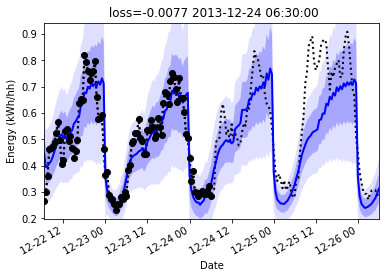

step val 30729, {'val_loss': '-0.010350431315600872', 'val/kl': '0.00014179287245497108', 'val/mse': '0.008877242915332317', 'val/std': '0.100741907954216'}


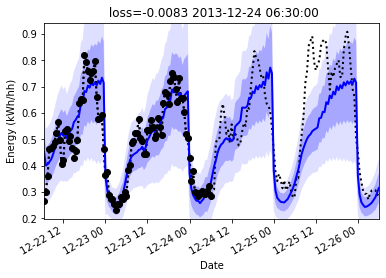

step val 32924, {'val_loss': '-0.010380413383245468', 'val/kl': '0.00014492945047095418', 'val/mse': '0.008874984458088875', 'val/std': '0.10127216577529907'}


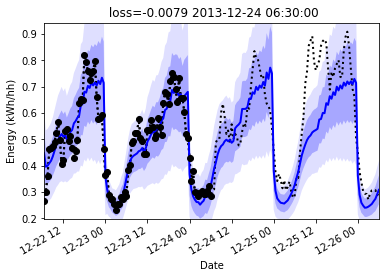

step val 35119, {'val_loss': '-0.010439630597829819', 'val/kl': '0.0001411951525369659', 'val/mse': '0.00880834087729454', 'val/std': '0.10017534345388412'}


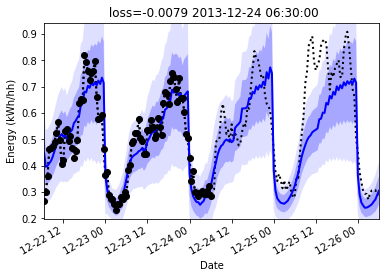

step val 37314, {'val_loss': '-0.010456354357302189', 'val/kl': '0.00014142670261207968', 'val/mse': '0.008787729777395725', 'val/std': '0.10053124278783798'}


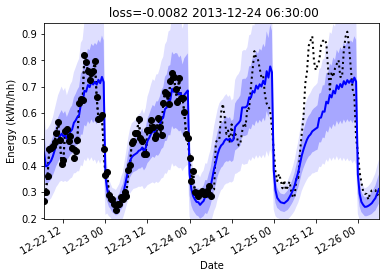

step val 39509, {'val_loss': '-0.010457227006554604', 'val/kl': '0.0001395221916027367', 'val/mse': '0.008772503584623337', 'val/std': '0.10096602141857147'}


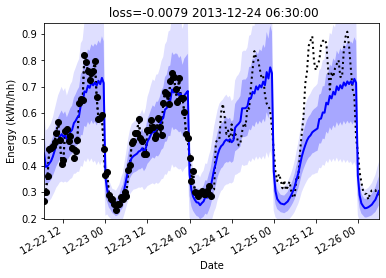

step val 41704, {'val_loss': '-0.010382249020040035', 'val/kl': '0.00014192007074598223', 'val/mse': '0.008815578185021877', 'val/std': '0.1015620008111'}


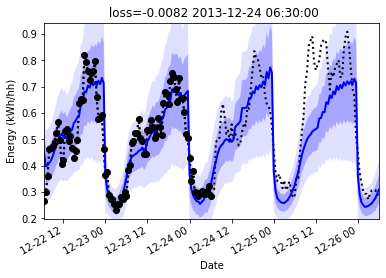

step val 43899, {'val_loss': '-0.010463825426995754', 'val/kl': '0.0001389776007272303', 'val/mse': '0.008798140101134777', 'val/std': '0.10005888342857361'}



INFO:root:
                                        Name           Type Params
0                                      model    LatentModel  357 K
1                      model._latent_encoder  LatentEncoder   62 K
2             model._latent_encoder._encoder      LSTMBlock   53 K
3       model._latent_encoder._encoder._lstm           LSTM   53 K
4   model._latent_encoder._penultimate_layer         Linear    4 K
..                                       ...            ...    ...
84          model._decoder._target_transform         Linear    1 K
85                   model._decoder._decoder      LSTMBlock  147 K
86             model._decoder._decoder._lstm           LSTM  147 K
87                      model._decoder._mean         Linear   97  
88                       model._decoder._std         Linear   97  

[89 rows x 3 columns]
INFO:root:model and trainer restored from checkpoint: optuna_result/anp-rnn4/anp-lstm2/version_-3/chk/_ckpt_epoch_19.ckpt


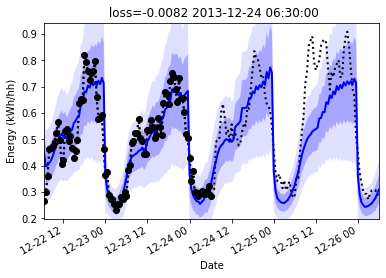

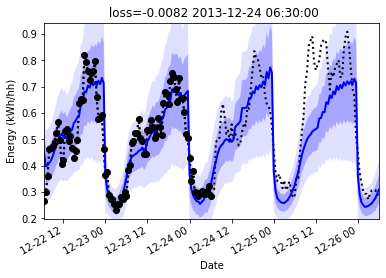

step val 43899, {'val_loss': '-0.011140062473714352', 'val/kl': '0.00011382201773812994', 'val/mse': '0.00865857768803835', 'val/std': '0.09592592716217041'}

logger.metrics [{'val_loss': -0.011140062473714352, 'val/kl': 0.00011382201773812994, 'val/mse': 0.00865857768803835, 'val/std': 0.09592592716217041, 'epoch': 19}]
None


In [23]:
trainer, model, params, r = try_manual({ 
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': False,
    'use_self_attn': False,
    'use_lstm_le': True,
    'use_lstm_d': True,
    'n_decoder_layers': 2,
    'n_det_encoder_layers': 2,
}, name='anp-lstm2')

trial.number -3
{'params': {'learning_rate': 0.0002, 'hidden_dim': 128, 'latent_dim': 16, 'attention_layers': 2, 'n_latent_encoder_layers': 2, 'n_det_encoder_layers': 4, 'n_decoder_layers': 4, 'dropout': 0.2, 'attention_dropout': 0, 'latent_enc_self_attn_type': 'uniform', 'det_enc_self_attn_type': 'uniform', 'det_enc_cross_attn_type': 'multihead', 'batchnorm': False, 'use_self_attn': False, 'use_lvar': False, 'use_deterministic_path': False, 'use_rnn': False, 'use_lstm_le': True, 'use_lstm_de': False, 'use_lstm_d': True}, 'user_attrs': {'batch_size': 16, 'grad_clip': 40, 'max_nb_epochs': 20, 'num_workers': 4, 'target_length': 24, 'vis_i': '670', 'num_context': 96, 'num_extra_target': 96, 'min_std': 0.005, 'num_heads': 8, 'context_in_target': True, 'x_dim': 17, 'y_dim': 1}}


INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
INFO:root:
                                        Name           Type Params
0                                      model    LatentModel    1 M
1                      model._latent_encoder  LatentEncoder  226 K
2             model._latent_encoder._encoder      LSTMBlock  205 K
3       model._latent_encoder._encoder._lstm           LSTM  205 K
4   model._latent_encoder._penultimate_layer         Linear   16 K
..                                       ...            ...    ...
92          model._decoder._target_transform         Linear    2 K
93                   model._decoder._decoder      LSTMBlock  663 K
94             model._decoder._decoder._lstm           LSTM  663 K
95                      model._decoder._mean         Linear  145  
96                       model._decoder._std         Linear  145  

[97 rows x 3 columns]


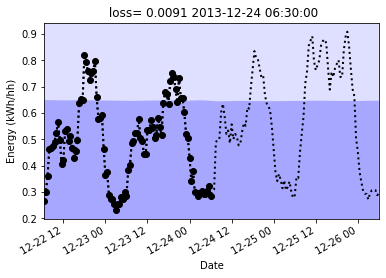

step val 0, {'val_loss': '0.00868173222988844', 'val/kl': '1.4223513971955981e-05', 'val/mse': '0.3091347813606262', 'val/std': '0.6782683730125427'}


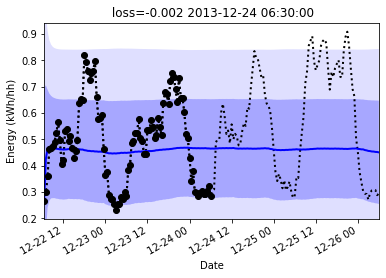

step val 2194, {'val_loss': '-0.00220436486415565', 'val/kl': '2.938839145372185e-07', 'val/mse': '0.03687189519405365', 'val/std': '0.20702660083770752'}


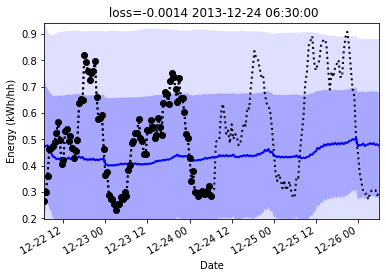

step val 4389, {'val_loss': '-0.0019156599882990122', 'val/kl': '1.4331061493066954e-06', 'val/mse': '0.037138525396585464', 'val/std': '0.23166042566299438'}


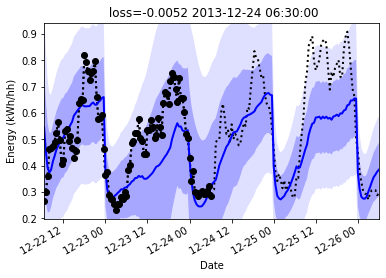

step val 6584, {'val_loss': '-0.0057923560962080956', 'val/kl': '0.0011892403708770871', 'val/mse': '0.014471719041466713', 'val/std': '0.13829636573791504'}


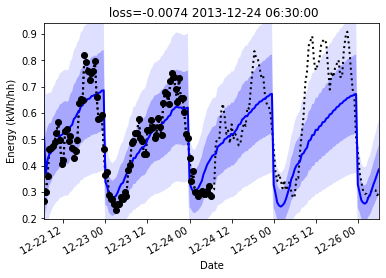

step val 8779, {'val_loss': '-0.00879998505115509', 'val/kl': '0.00030224185320548713', 'val/mse': '0.010459517128765583', 'val/std': '0.11564823985099792'}


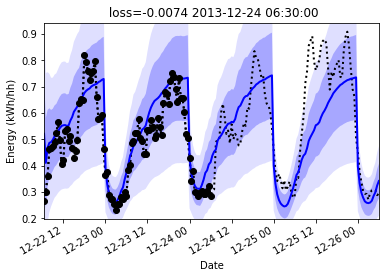

step val 10974, {'val_loss': '-0.008512335829436779', 'val/kl': '0.00018694093159865588', 'val/mse': '0.011850623413920403', 'val/std': '0.11690759658813477'}


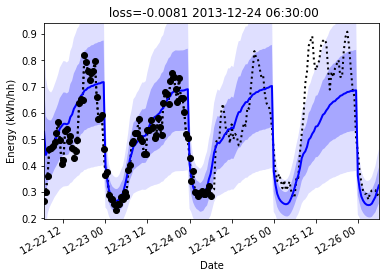

step val 13169, {'val_loss': '-0.008924140594899654', 'val/kl': '0.00028845659107901156', 'val/mse': '0.011009116657078266', 'val/std': '0.1132839173078537'}


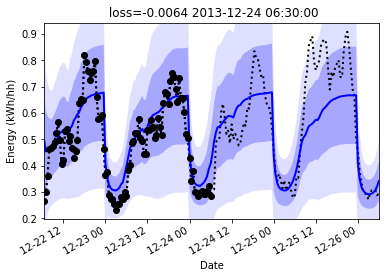

step val 15364, {'val_loss': '-0.008349238894879818', 'val/kl': '0.0004312678938731551', 'val/mse': '0.010706685483455658', 'val/std': '0.13060510158538818'}


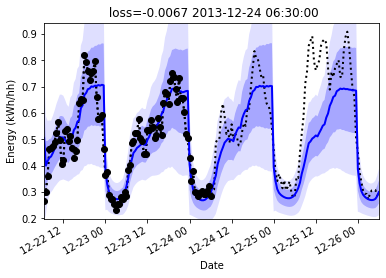

step val 17559, {'val_loss': '-0.01090719923377037', 'val/kl': '0.00022727491159457713', 'val/mse': '0.008385194465517998', 'val/std': '0.09534289687871933'}


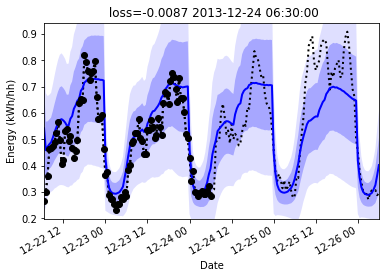

step val 19754, {'val_loss': '-0.008542833849787712', 'val/kl': '0.00027246144600212574', 'val/mse': '0.0123121477663517', 'val/std': '0.12256549298763275'}


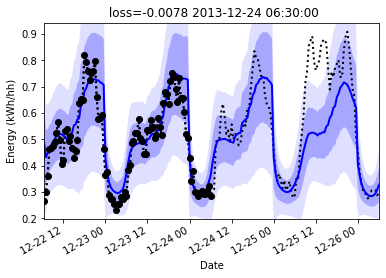

step val 21949, {'val_loss': '-0.009440659545361996', 'val/kl': '0.00020619103452190757', 'val/mse': '0.009264436550438404', 'val/std': '0.12026706337928772'}
Epoch     9: reducing learning rate of group 0 to 2.0000e-05.


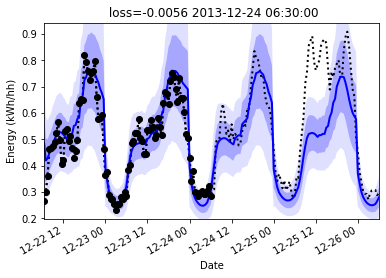

step val 24144, {'val_loss': '-0.01136733591556549', 'val/kl': '0.00016490866255480796', 'val/mse': '0.007215595338493586', 'val/std': '0.09338495880365372'}


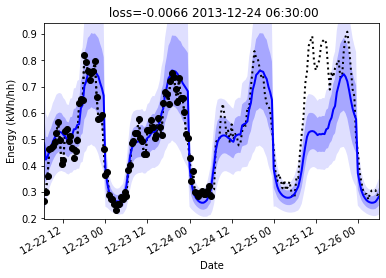

step val 26339, {'val_loss': '-0.011439336463809013', 'val/kl': '0.000161058793310076', 'val/mse': '0.006865694187581539', 'val/std': '0.09241525828838348'}


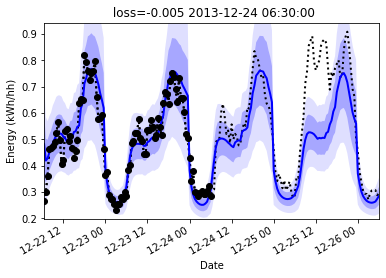

step val 28534, {'val_loss': '-0.011696096509695053', 'val/kl': '0.00013111541920807213', 'val/mse': '0.00643901014700532', 'val/std': '0.08725713193416595'}


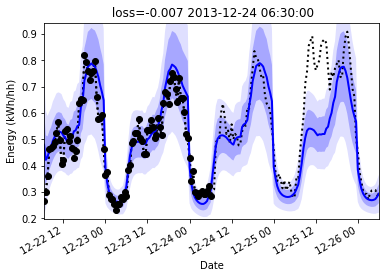

step val 30729, {'val_loss': '-0.012062464840710163', 'val/kl': '0.0001506595581304282', 'val/mse': '0.0060098906978964806', 'val/std': '0.08937463164329529'}


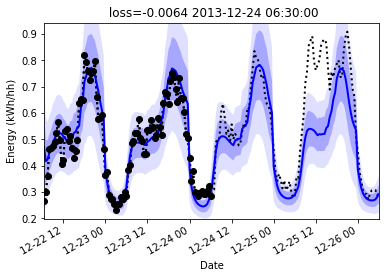

step val 32924, {'val_loss': '-0.012067064642906189', 'val/kl': '0.00013129020226188004', 'val/mse': '0.00601418549194932', 'val/std': '0.08661390841007233'}


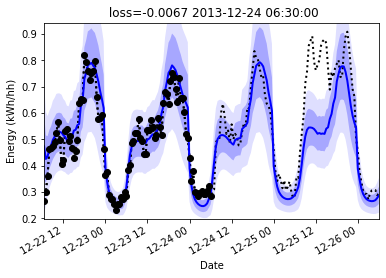

step val 35119, {'val_loss': '-0.012112884782254696', 'val/kl': '0.0001443344372091815', 'val/mse': '0.0058594150468707085', 'val/std': '0.08837384730577469'}


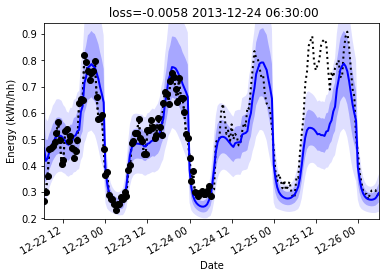

step val 37314, {'val_loss': '-0.012062818743288517', 'val/kl': '0.00013888548710383475', 'val/mse': '0.00598512077704072', 'val/std': '0.08429467678070068'}


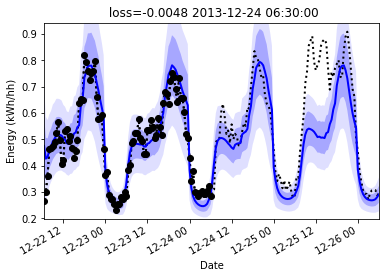

step val 39509, {'val_loss': '-0.012109644711017609', 'val/kl': '0.00012263900134712458', 'val/mse': '0.005824161693453789', 'val/std': '0.08178030699491501'}
Epoch    17: reducing learning rate of group 0 to 2.0000e-06.


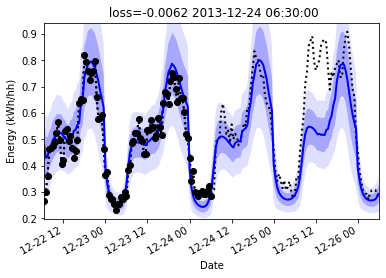

step val 41704, {'val_loss': '-0.012216373346745968', 'val/kl': '0.00012300258094910532', 'val/mse': '0.0057160803116858006', 'val/std': '0.08580853044986725'}


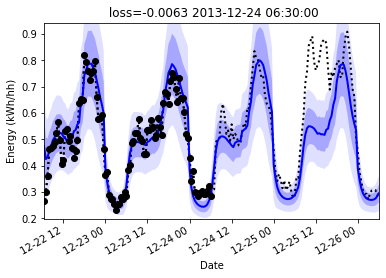

step val 43899, {'val_loss': '-0.01225808821618557', 'val/kl': '0.0001240428100572899', 'val/mse': '0.005709941498935223', 'val/std': '0.08506008982658386'}



INFO:root:
                                        Name           Type Params
0                                      model    LatentModel    1 M
1                      model._latent_encoder  LatentEncoder  226 K
2             model._latent_encoder._encoder      LSTMBlock  205 K
3       model._latent_encoder._encoder._lstm           LSTM  205 K
4   model._latent_encoder._penultimate_layer         Linear   16 K
..                                       ...            ...    ...
92          model._decoder._target_transform         Linear    2 K
93                   model._decoder._decoder      LSTMBlock  663 K
94             model._decoder._decoder._lstm           LSTM  663 K
95                      model._decoder._mean         Linear  145  
96                       model._decoder._std         Linear  145  

[97 rows x 3 columns]
INFO:root:model and trainer restored from checkpoint: optuna_result/anp-rnn4/anp-lstmbig/version_-3/chk/_ckpt_epoch_19.ckpt


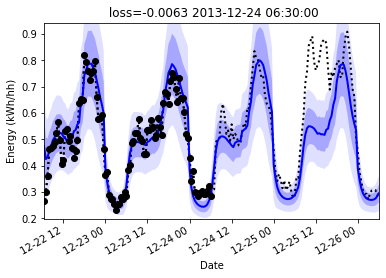

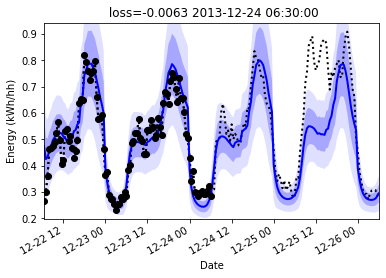

step val 43899, {'val_loss': '-0.012918490916490555', 'val/kl': '9.250699076801538e-05', 'val/mse': '0.00538375461474061', 'val/std': '0.08190043270587921'}

logger.metrics [{'val_loss': -0.012918490916490555, 'val/kl': 9.250699076801538e-05, 'val/mse': 0.00538375461474061, 'val/std': 0.08190043270587921, 'epoch': 19}]
None


In [24]:
trainer, model, params, r = try_manual({ 
    'use_deterministic_path': False,
    'use_rnn': False,
    'use_lvar': False,
    'use_self_attn': False,
    'use_lstm_le': True,
    'use_lstm_d': True,
    'n_decoder_layers': 4,
    'n_det_encoder_layers': 4,
    'dropout': 0.2,
    'hidden_dim': 128,
    'latent_dim': 16,
}, name='anp-lstmbig')

# Train ANP-RNN

In [ ]:
trainer, model, params, r = try_manual({ 
    'det_enc_cross_attn_type': 'multihead',
    'det_enc_self_attn_type': 'uniform',
    'latent_enc_self_attn_type': 'uniform',
    'use_deterministic_path': True,
    'use_rnn': True
}, name='anp-rnn')

# ANP-RNN 2

In [ ]:
trainer, model, params, r = try_manual({ 
 'use_deterministic_path': False,
 'use_rnn': True,
 'use_lvar': False,
}, name='anp-rnn3')

In [ ]:
# # plot lots of metrics
# loader = model.val_dataloader()[0]
# for i in range(0, len(loader), 10):
#     plot_from_loader(loader, model, i=i)
#     plt.show()

# ANP

In [ ]:
trainer, model, params, r = try_manual({ 
 'det_enc_cross_attn_type': 'multihead',
 'det_enc_self_attn_type': 'multihead',
 'latent_enc_self_attn_type': 'multihead',
 'use_deterministic_path': True,
}, name='anp')

# NP

In [ ]:
trainer, model, params, r = try_manual({ 
 'det_enc_cross_attn_type': 'uniform',
 'det_enc_self_attn_type': 'uniform',
 'latent_enc_self_attn_type': 'uniform',
 'use_deterministic_path': False,
}, name='np')


# Hyperparam

In [ ]:
def objective(trial):
    """Funtion for optuna hyperparam tuning"""
    # see https://github.com/optuna/optuna/blob/cf6f02d/examples/pytorch_lightning_simple.py
    
    trial = add_sugg(trial)
    
#     print('trial', trial.number, 'params', trial.params)
    
    
    # PyTorch Lightning will try to restore model parameters from previous trials if checkpoint
    # filenames match. Therefore, the filenames for each trial must be made unique.
    model, trainer = main(trial, train=True, optuna=True)
    
    # also report to tensorboard & print
    print('logger.metrics', model.logger.metrics[-1:])
    model.logger.experiment.add_hparams(trial.params, model.logger.metrics[-1])
    
    return model.logger.metrics[-1]['val_loss']


In [ ]:
import argparse 

parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
parser.add_argument('--pruning', '-p', action='store_true',
                    help='Activate the pruning feature. `MedianPruner` stops unpromising '
                         'trials at the early stages of training.')
args = parser.parse_args(['-p'])

# pruner = optuna.pruners.MedianPruner(n_warmup_steps=1, n_startup_trials=20) if args.pruning else optuna.pruners.NopPruner()
pruner = optuna.pruners.PercentilePruner(75.0)
name = 'anp-rnn1'
study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name=name, load_if_exists=True)
study.user_attrs = user_attrs


In [ ]:
study.optimize(objective, n_trials=200, timeout=pd.Timedelta('3d').total_seconds())

In [ ]:

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# shutil.rmtree(MODEL_DIR)

## View

TODO

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

In [ ]:
df.sort_values('value').head(17).T

## Scratch

In [ ]:
"""Run a manual trial using optuna"""
params={}
params = {
    **default_params, 
    **params
}
trial = optuna.trial.FixedTrial(params)
trial = add_sugg(trial, name=name)
print(dict(params=trial.params, user_attrs=trial.user_attrs))


In [ ]:
"""Setup pytorch lightning train."""
name='scratch'
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    os.path.join(MODEL_DIR, name, 'version_{}'.format(trial.number), "chk"), monitor='val_loss', mode="min")

# The default logger in PyTorch Lightning writes to event files to be consumed by
# TensorBoard. We create a simple logger instead that holds the log in memory so that the
# final accuracy can be obtained after optimization. When using the default logger, the
# final accuracy could be stored in an attribute of the `Trainer` instead.
logger = DictLogger(MODEL_DIR, name=name, version=trial.number)

if optuna:
    early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
else:
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        min_delta=0.00,
        patience=2,
        verbose=True,
        mode='min'
    )


trainer = pl.Trainer(
    logger=logger,
    val_percent_check=PERCENT_TEST_EXAMPLES,
    gradient_clip_val=trial.user_attrs["grad_clip"],
    checkpoint_callback=checkpoint_callback,
    max_epochs=trial.user_attrs['max_nb_epochs'],
    gpus=-1 if torch.cuda.is_available() else None,
    early_stop_callback=PyTorchLightningPruningCallback(trial, monitor='val_loss')
)
model = LatentModelPL(dict(**trial.params, **trial.user_attrs))

trainer.fit(model)


In [ ]:

# plot, main metric
loader = model.val_dataloader()[0]
vis_i=670
plot_from_loader(loader, model, i=vis_i)


In [ ]:
%debug